# Lab 4 - (discrete) AutoEncoder

## Plan for today

* train a basic Autoencoder
* try out two ways of differentially sampling from a discrete distribution
  * score function
  * Gumbel-softmax
* train a discrete autoencoder using those two methods

In [1]:
import torch
from torch.optim import SGD
from torch import nn
import torch
from typing import List
from torchvision.datasets import MNIST
from torchvision import transforms as tv
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from time import sleep
from torchvision.models import vgg16, vgg16_bn, resnet50, resnet18
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter
from typing import Tuple

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
ds_train = MNIST(root="data", train=True, download=True, transform=tv.ToTensor())

ds_test = MNIST(root="data", train=False, download=True, transform=tv.ToTensor())


In [4]:
batch_size=128
dl_train = DataLoader(ds_train, batch_size, shuffle=True, drop_last=False) # dataloader with full dataset 

dl_test = DataLoader(ds_test, batch_size, shuffle=False)


## 1 - Warmup: vanilla AutoEncoder

Let's start with training a classic AutoEncoder on MNIST. The architecture and training loop have been provided below.



In [5]:
class Reshape(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape
  
  def forward(self, x):
    return x.reshape(-1, *self.shape)

In [6]:
class AE(nn.Module):
  def __init__(self, hidden_sizes: List[int], downsize_steps: List[int], chw: int = (1, 28, 28), latent_size: int = 128):
    """
    Args:
      hidden sizes - hidden size of each consecutive convolution
      downsize_steps - numbers of convolutions for which there will be stride = 2
      chw - size of the input image
      latent_size: latent dimension
    
    Forward method returns the reconstructed batch *and* the latent vectors.
    """
    super().__init__()

    c, h, w = chw

    conv_1 = nn.Conv2d(c, hidden_sizes[0], 3, padding=1)
    conv_n = nn.ConvTranspose2d(hidden_sizes[0], c, 3, padding=1)

    encoder = []
    decoder = []

    ht, wt = h, w

    for i, (in_hs, out_hs) in enumerate(zip(hidden_sizes[:-1], hidden_sizes[1:])):
      downsize = (i in downsize_steps)
      encoder.append(nn.Sequential(
          nn.Conv2d(
              in_hs, out_hs, 3, padding=1,
              stride=2 if downsize else 1
          ),
          nn.BatchNorm2d(out_hs),
          nn.ReLU()
      ))

      decoder = [nn.Sequential(
          nn.ConvTranspose2d( 
              out_hs, in_hs, 3, padding=1, output_padding=1,
              stride=2 if downsize else 1,
          ),
          nn.BatchNorm2d(in_hs),
          nn.ReLU()
      )] + decoder
      if downsize:
        ht = ht // 2
        wt = wt // 2
    
    le = nn.Sequential(
        nn.Flatten(),
        nn.Linear(ht * wt * hidden_sizes[-1], latent_size)
    )

    ld = nn.Sequential(
        nn.Linear(latent_size, ht * wt * hidden_sizes[-1]),
        Reshape((  hidden_sizes[-1], ht, wt))
    )
    self.encoder = nn.Sequential(conv_1, *encoder, le)
    self.decoder = nn.Sequential(ld, *decoder, conv_n)


  def forward(self, x):
    l = self.encoder(x)
    d = self.decoder(l)
    return d, l




In [7]:
def draw_reconstruction(original: torch.Tensor, expected: torch.Tensor, epoch: int):
  assert len(original) == len(expected)
  fig, ax = plt.subplots(nrows=2, ncols=len(original), figsize=(3*len(original), 6))
  
  for i, (o,e) in enumerate(zip(original, expected)):
    ax[0][i].imshow(o.squeeze())
    ax[1][i].imshow(e.squeeze())
  plt.suptitle(f"{epoch}: Original / expected")
  plt.show()

In [8]:
def train_ae(net, train_dl, test_dl, num_epochs: int = 20, lr: float = 3e-4, loss_fn = None):

  net = net.to(device)
  loss_fn = loss_fn or nn.MSELoss()
  opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=3e-4)  
  
  history = []

  epoch_progress = tqdm(list(range(num_epochs)))
  for i in epoch_progress:
      train_loss = 0
      net.train()
      for iteration, (X_train, y_train) in enumerate(train_dl):
          X_train, y_train = [t.to(device) for t in [X_train, y_train]]
          opt.zero_grad()
          latent = net.encoder(X_train)
          X_pred = net.decoder(latent)
          loss = loss_fn(X_train, X_pred)
          loss.backward()
          opt.step()
          train_loss += loss.item()
          
      val_loss = 0
      net.eval()
      with torch.no_grad():
          for iteration, (X_val, y_val) in enumerate(test_dl):
              X_val, y_val = [t.to(device) for t in [X_val, y_val]]

              X_pred, _ = net(X_val)
              if iteration == 0:
                draw_reconstruction(
                    X_val[:10].detach().cpu().numpy(), X_pred[:10].detach().cpu().numpy(), epoch=i
                )
              loss = loss_fn(X_val, X_pred)
              val_loss += loss.item()
      
      epoch_progress.set_description(f'#Epoch: {i}, train loss: {train_loss:.2f}, val loss: {val_loss:.2f}')
      history.append({"e": i, "train_loss": train_loss, "val_loss": val_loss})
    
  for m in ["train_loss", "val_loss"]:
      plt.plot([h["e"] for h in history], [h[m] for h in history], label=m)
  
  plt.grid()
  plt.legend()
  plt.show()




### Task for you - train the autoencoder

* a relatively small model (2 convolutions in the encoder and 2 convolutions in the decoder) should suffice
* try out 2 different latent sizes 
* try out [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) or [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

  0%|          | 0/10 [00:00<?, ?it/s]

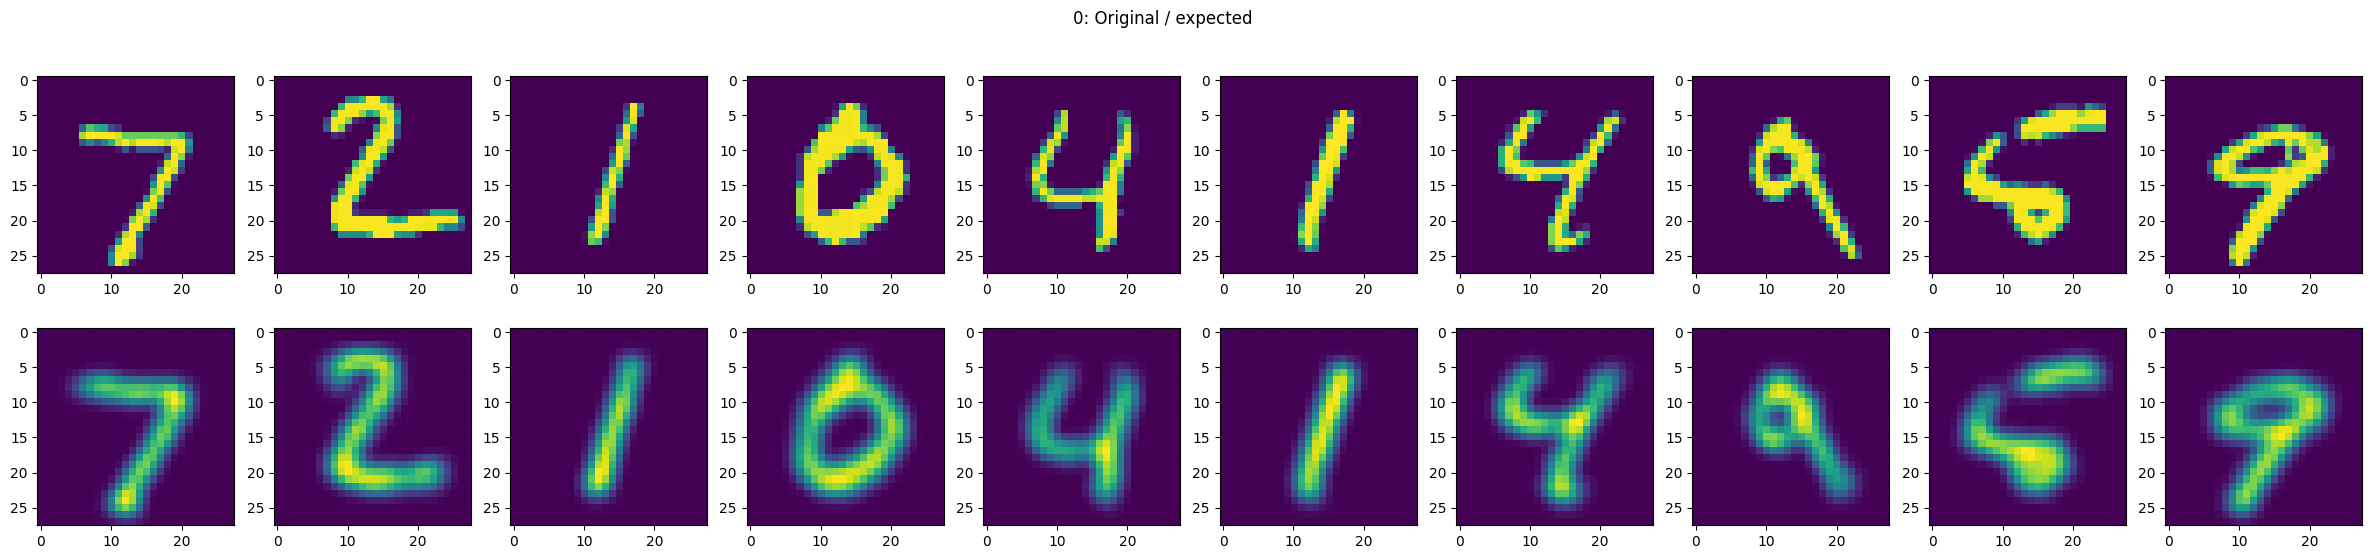

#Epoch: 0, train loss: -1556.14, val loss: -654.88:  10%|█         | 1/10 [02:08<19:13, 128.17s/it]

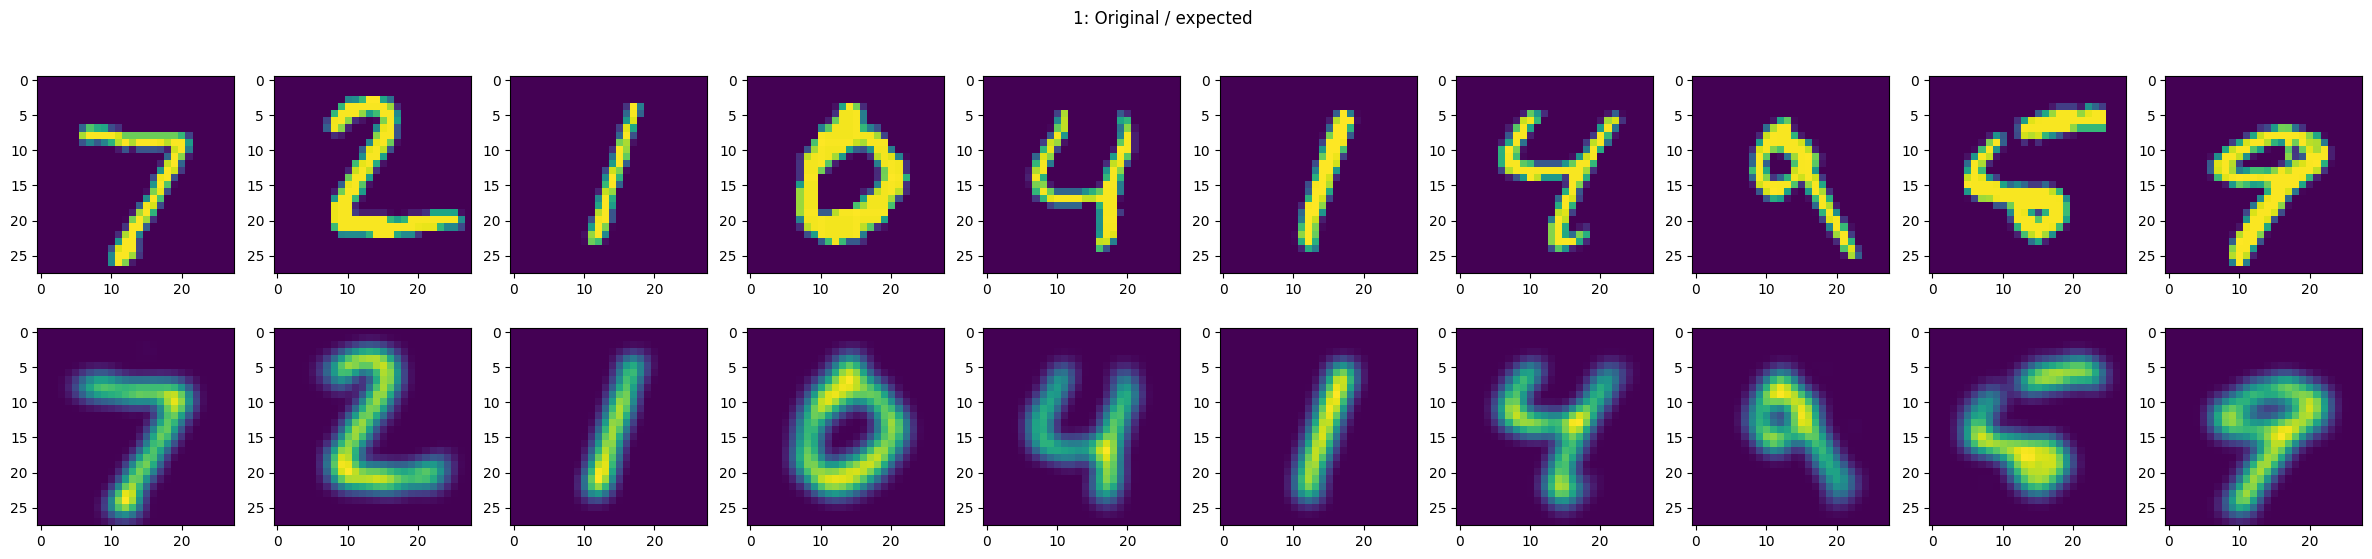

#Epoch: 1, train loss: -6360.63, val loss: -1607.54:  20%|██        | 2/10 [02:48<10:12, 76.60s/it] 

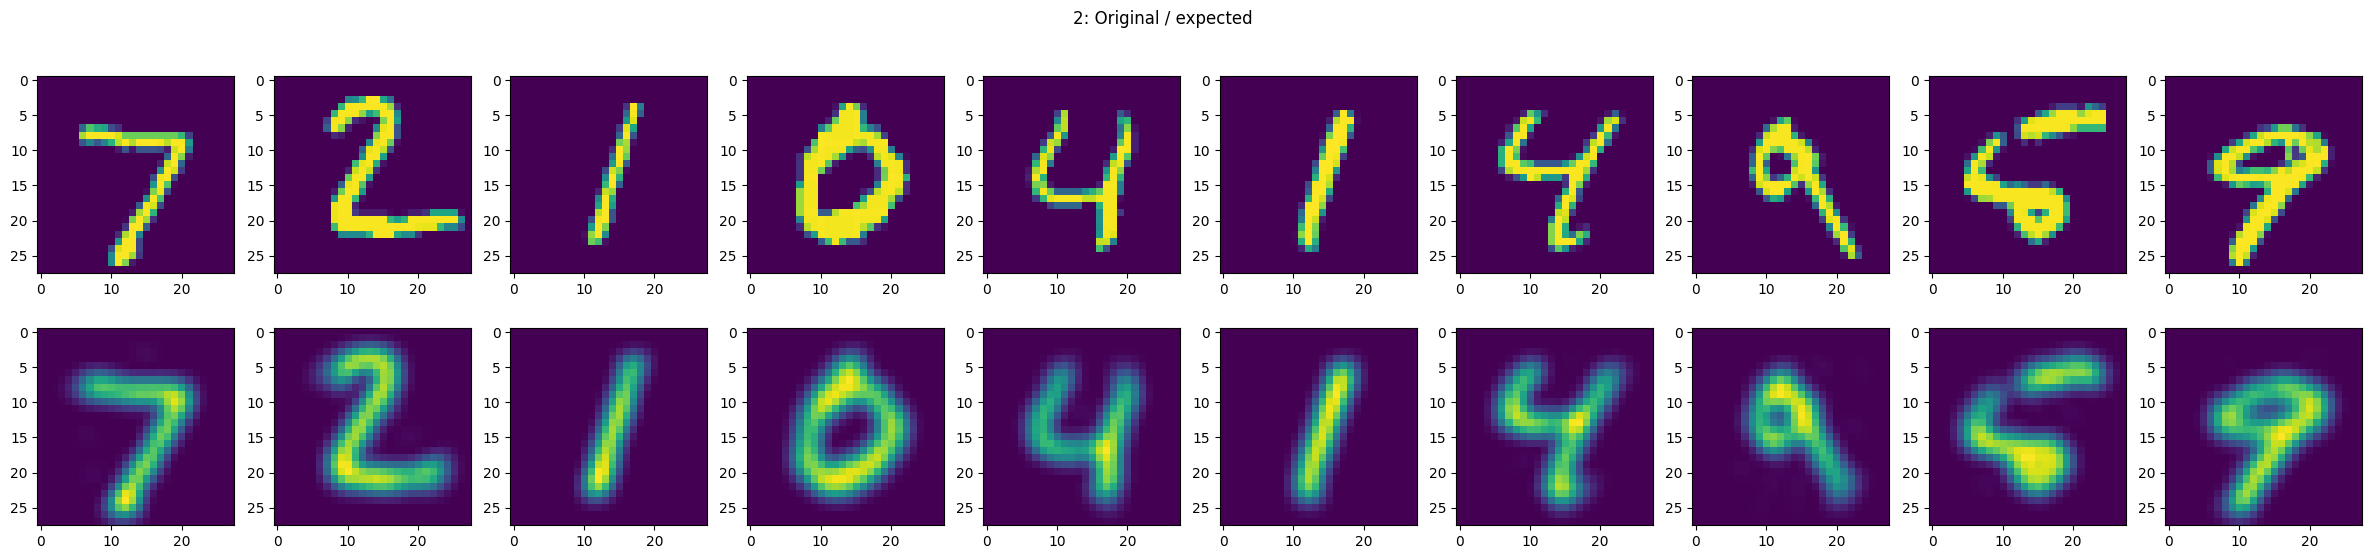

#Epoch: 2, train loss: -13095.30, val loss: -3007.76:  30%|███       | 3/10 [03:34<07:16, 62.38s/it]

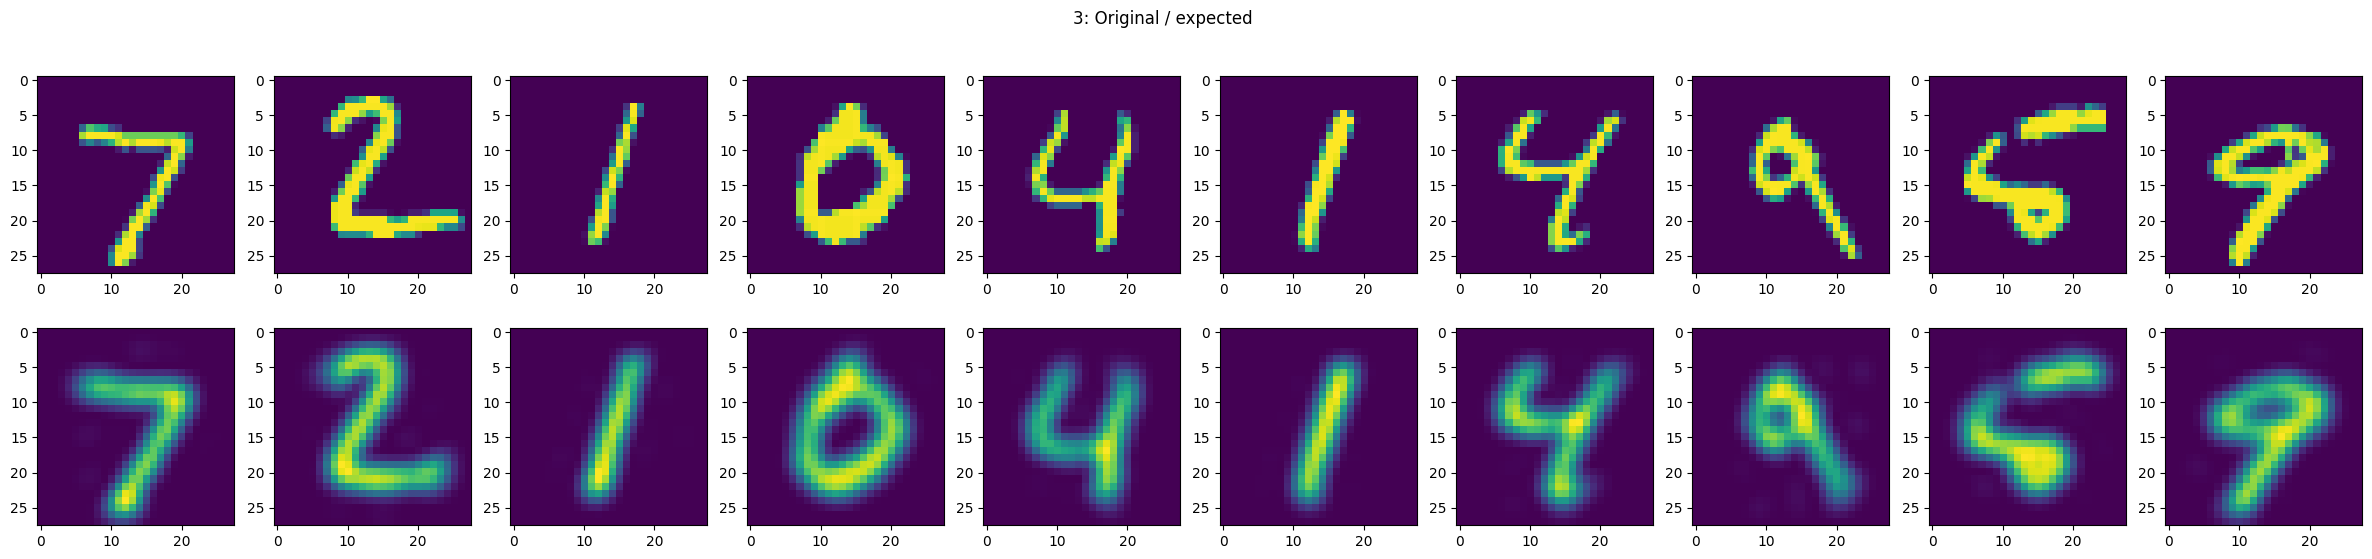

#Epoch: 3, train loss: -21619.55, val loss: -4545.21:  40%|████      | 4/10 [04:06<05:04, 50.72s/it]

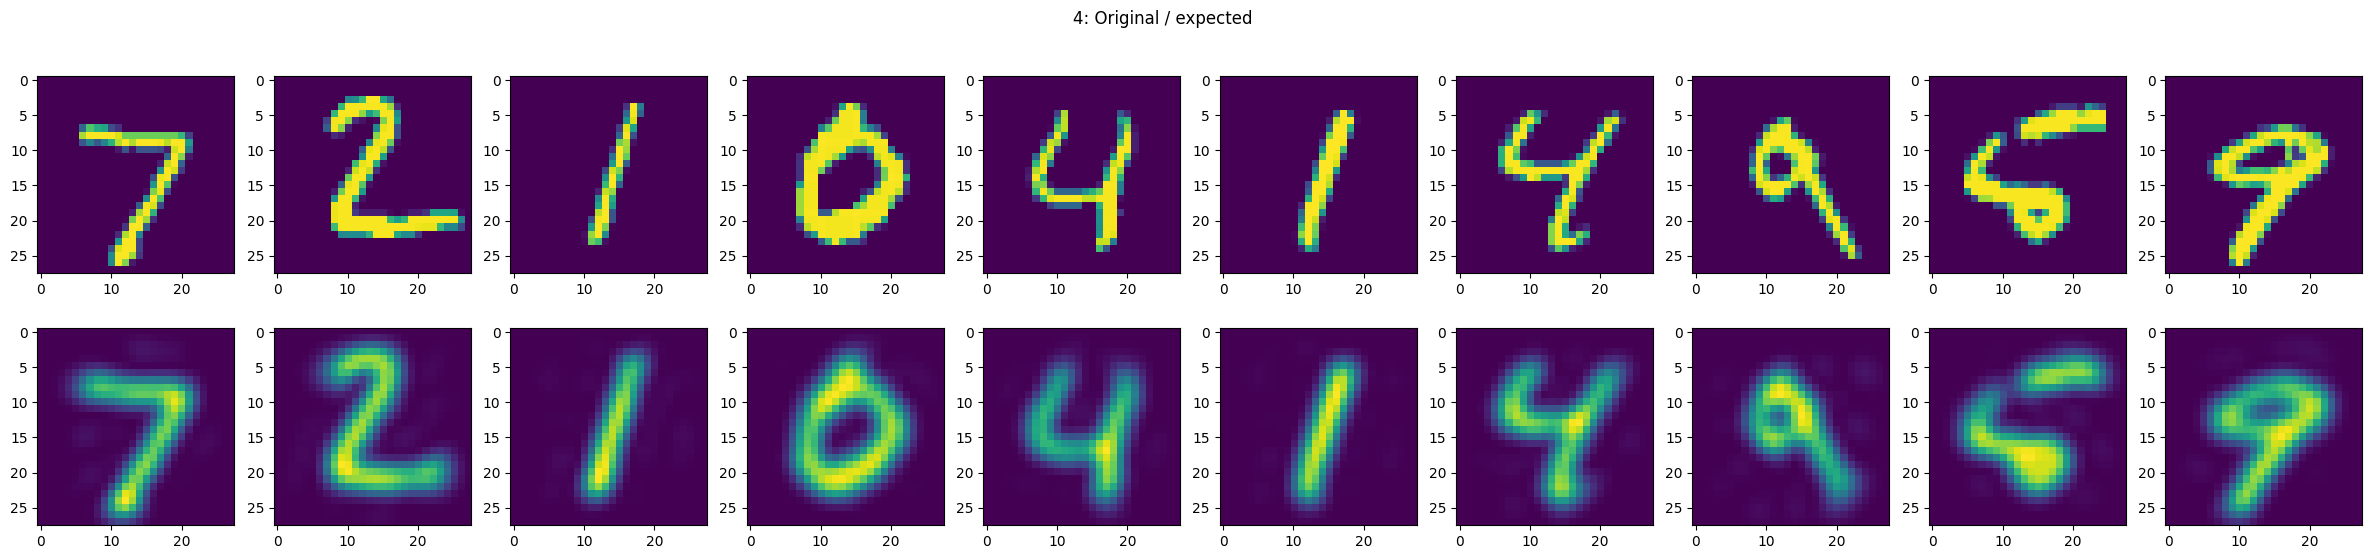

#Epoch: 4, train loss: -31931.02, val loss: -6466.43:  50%|█████     | 5/10 [04:45<03:51, 46.37s/it]

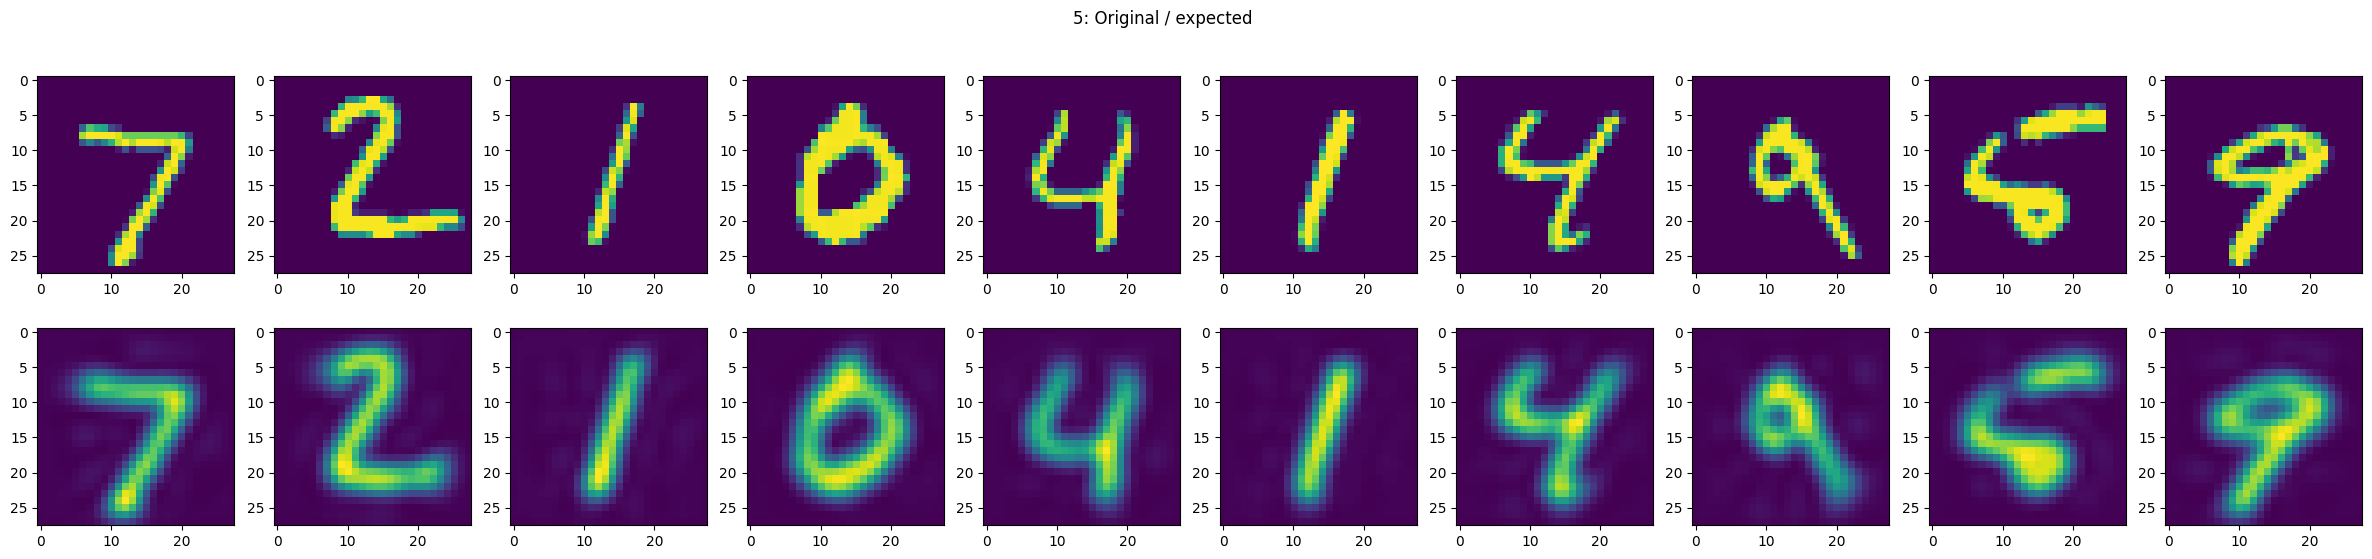

#Epoch: 5, train loss: -43808.98, val loss: -8881.30:  60%|██████    | 6/10 [05:42<03:19, 49.89s/it]

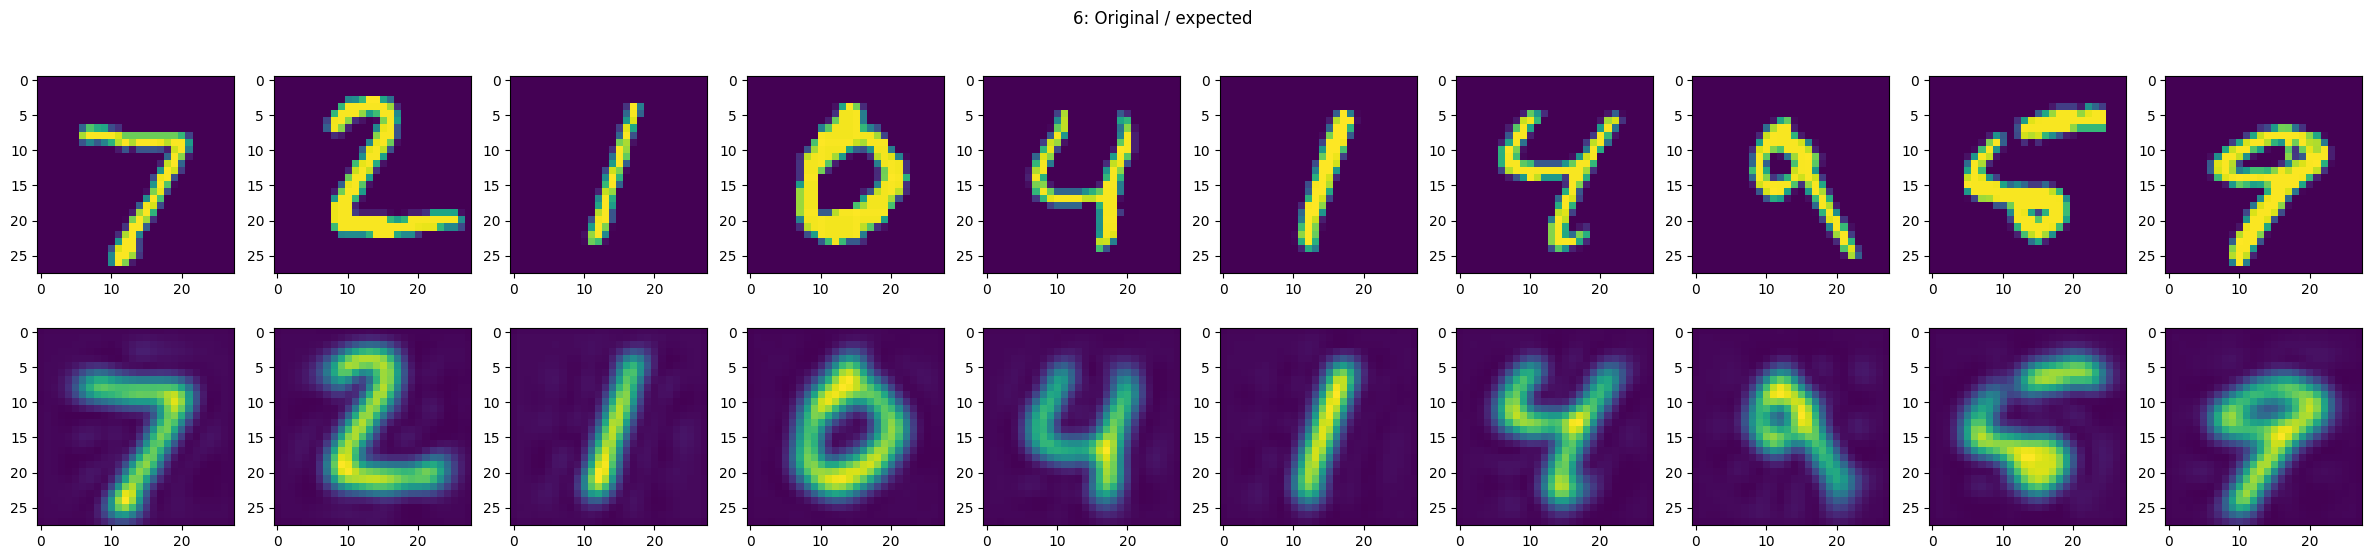

#Epoch: 6, train loss: -57031.66, val loss: -11122.59:  70%|███████   | 7/10 [06:23<02:21, 47.04s/it]

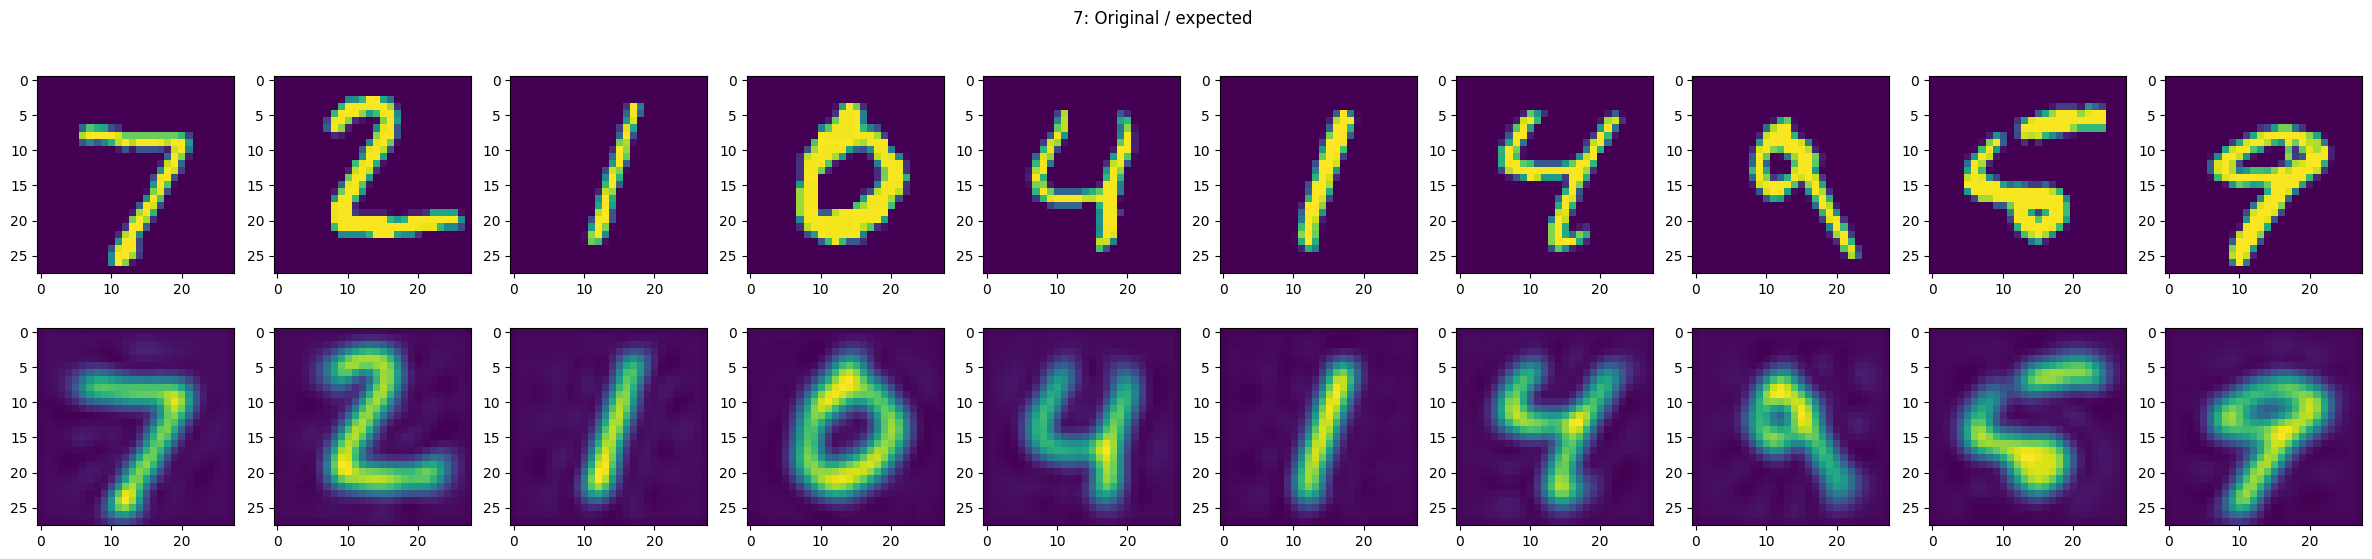

#Epoch: 7, train loss: -71582.39, val loss: -13766.87:  80%|████████  | 8/10 [07:03<01:29, 44.92s/it]

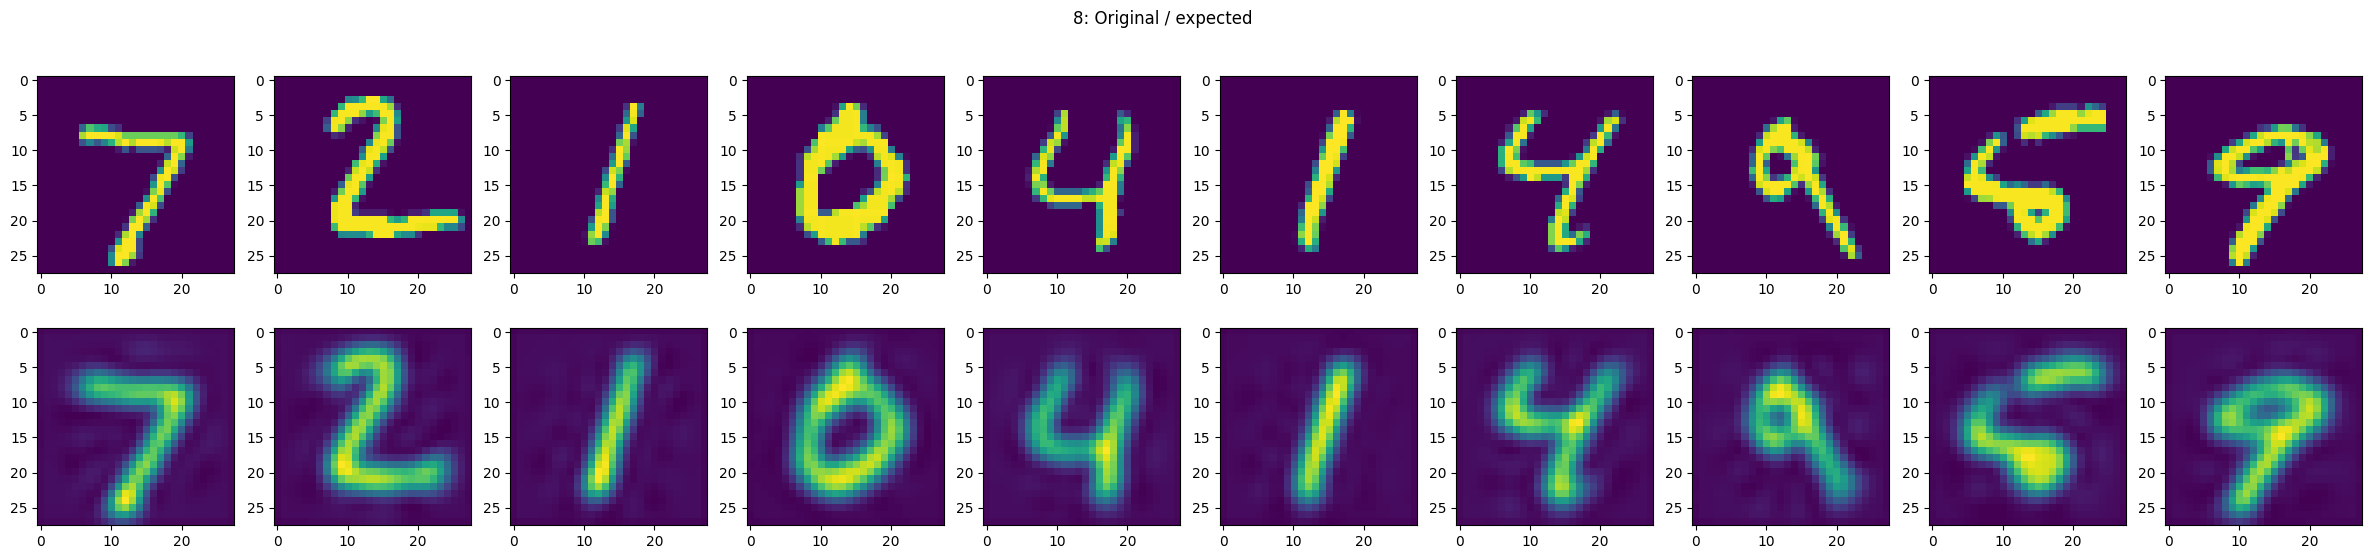

#Epoch: 8, train loss: -87401.93, val loss: -16525.18:  90%|█████████ | 9/10 [07:47<00:44, 44.38s/it]

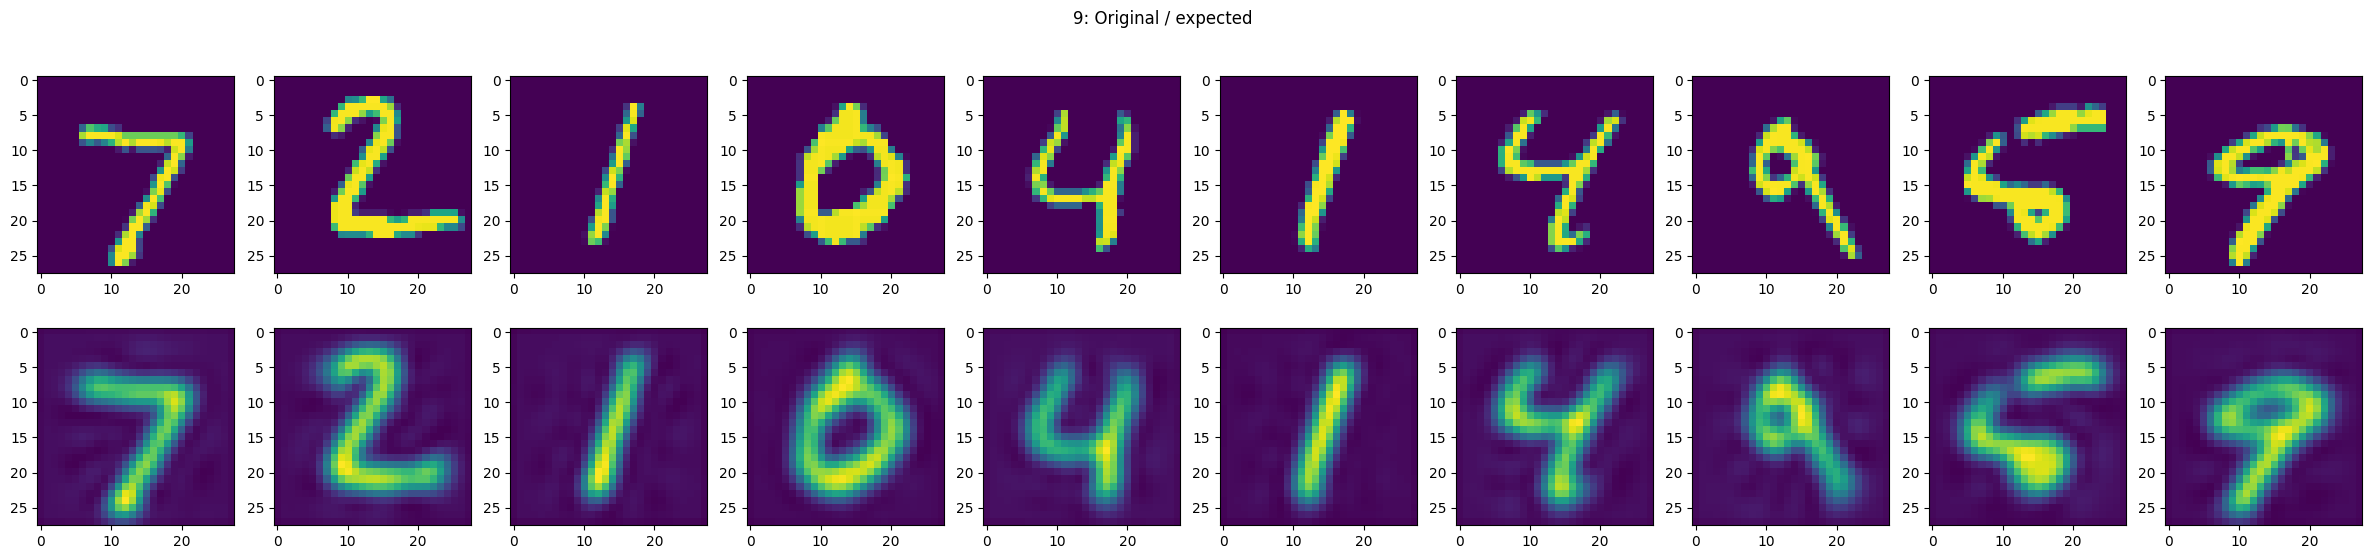

#Epoch: 9, train loss: -104453.96, val loss: -19606.89: 100%|██████████| 10/10 [08:19<00:00, 49.99s/it]


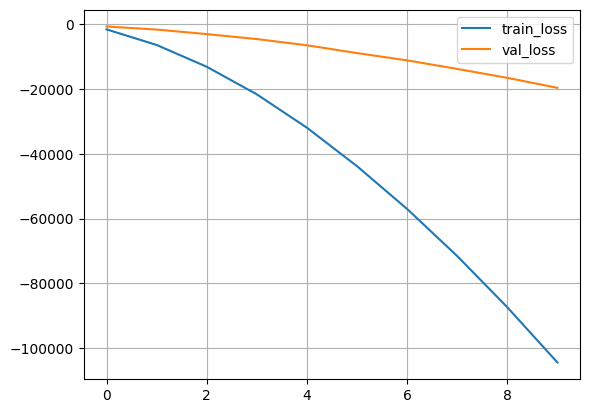

In [9]:
#ae = AE(..., latent_size=...)
# def __init__(self, hidden_sizes: List[int], downsize_steps: List[int], chw: int = (1, 28, 28), latent_size: int = 128):

ae1 = AE(hidden_sizes=[16,32], downsize_steps=[0, 1], latent_size=64)

train_ae(ae1, train_dl=dl_train, test_dl=dl_test, num_epochs=10, loss_fn=torch.nn.BCEWithLogitsLoss())



  0%|          | 0/10 [00:00<?, ?it/s]

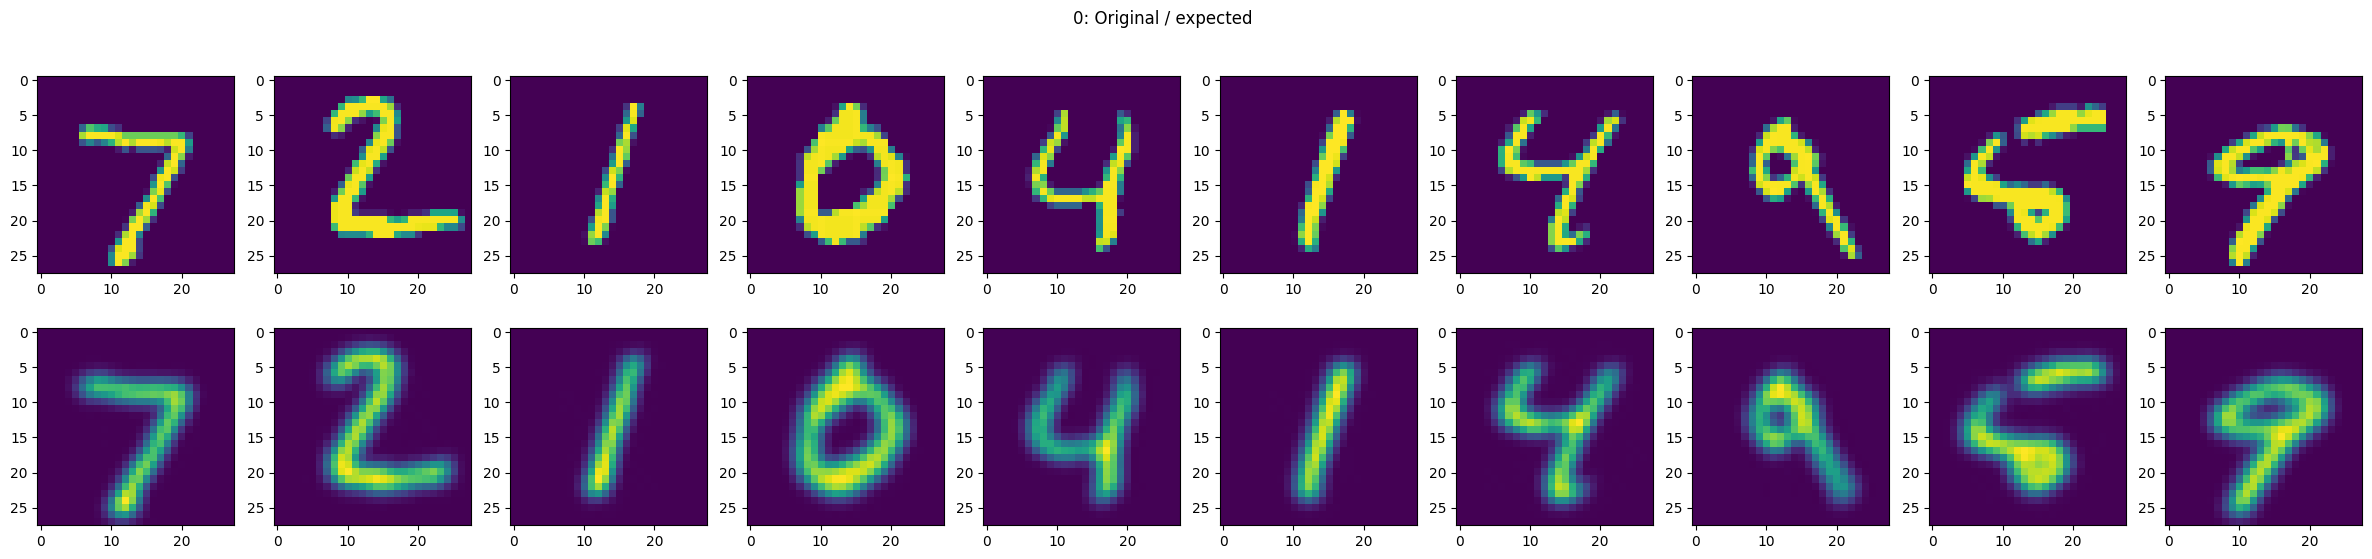

#Epoch: 0, train loss: -1481.86, val loss: -621.30:  10%|█         | 1/10 [00:33<05:00, 33.35s/it]

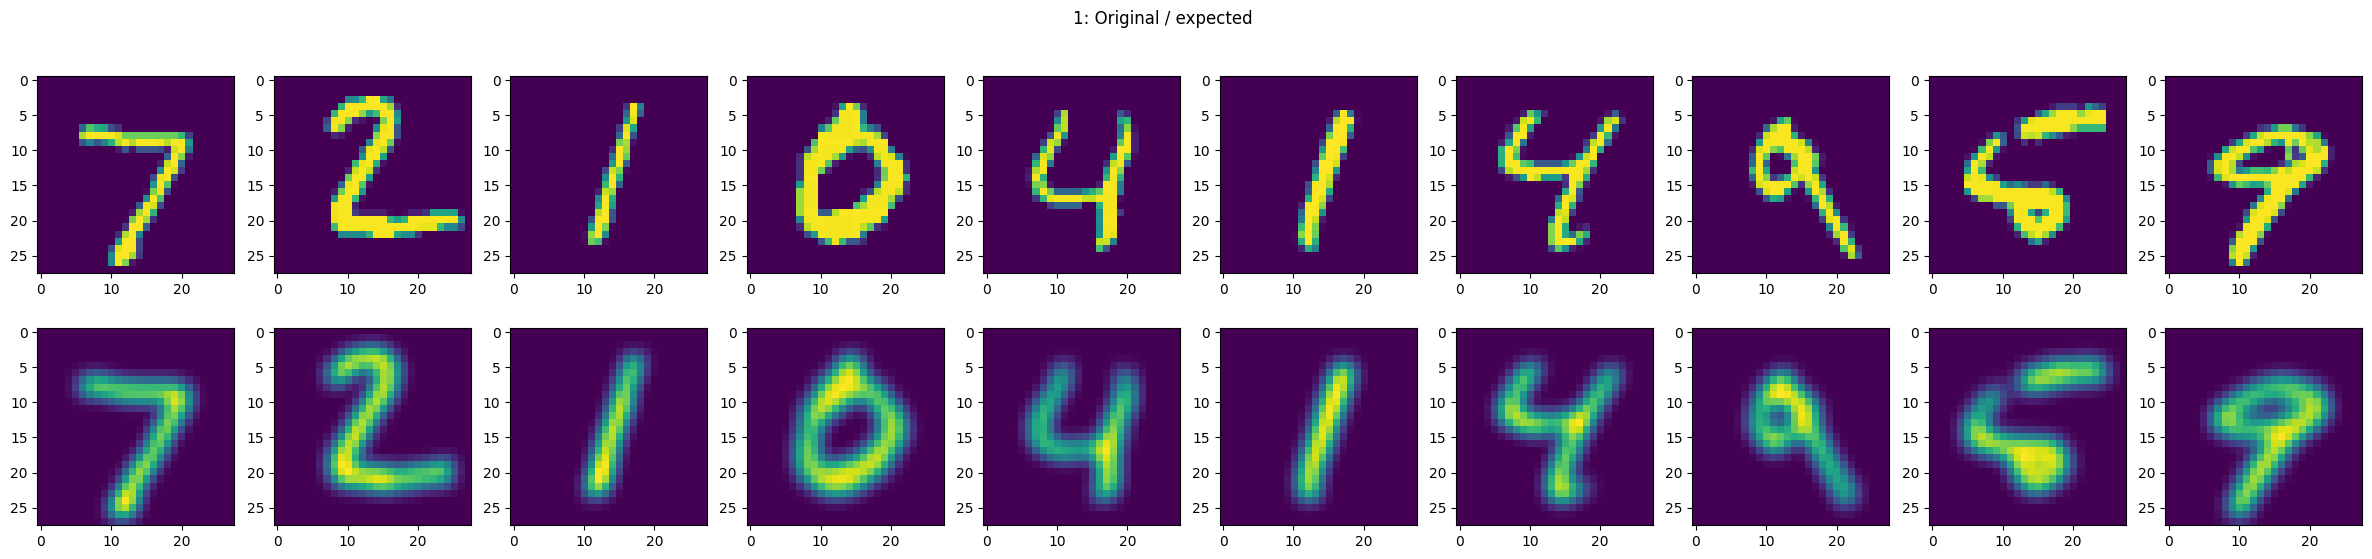

#Epoch: 1, train loss: -6445.63, val loss: -1691.52:  20%|██        | 2/10 [01:09<04:38, 34.85s/it]

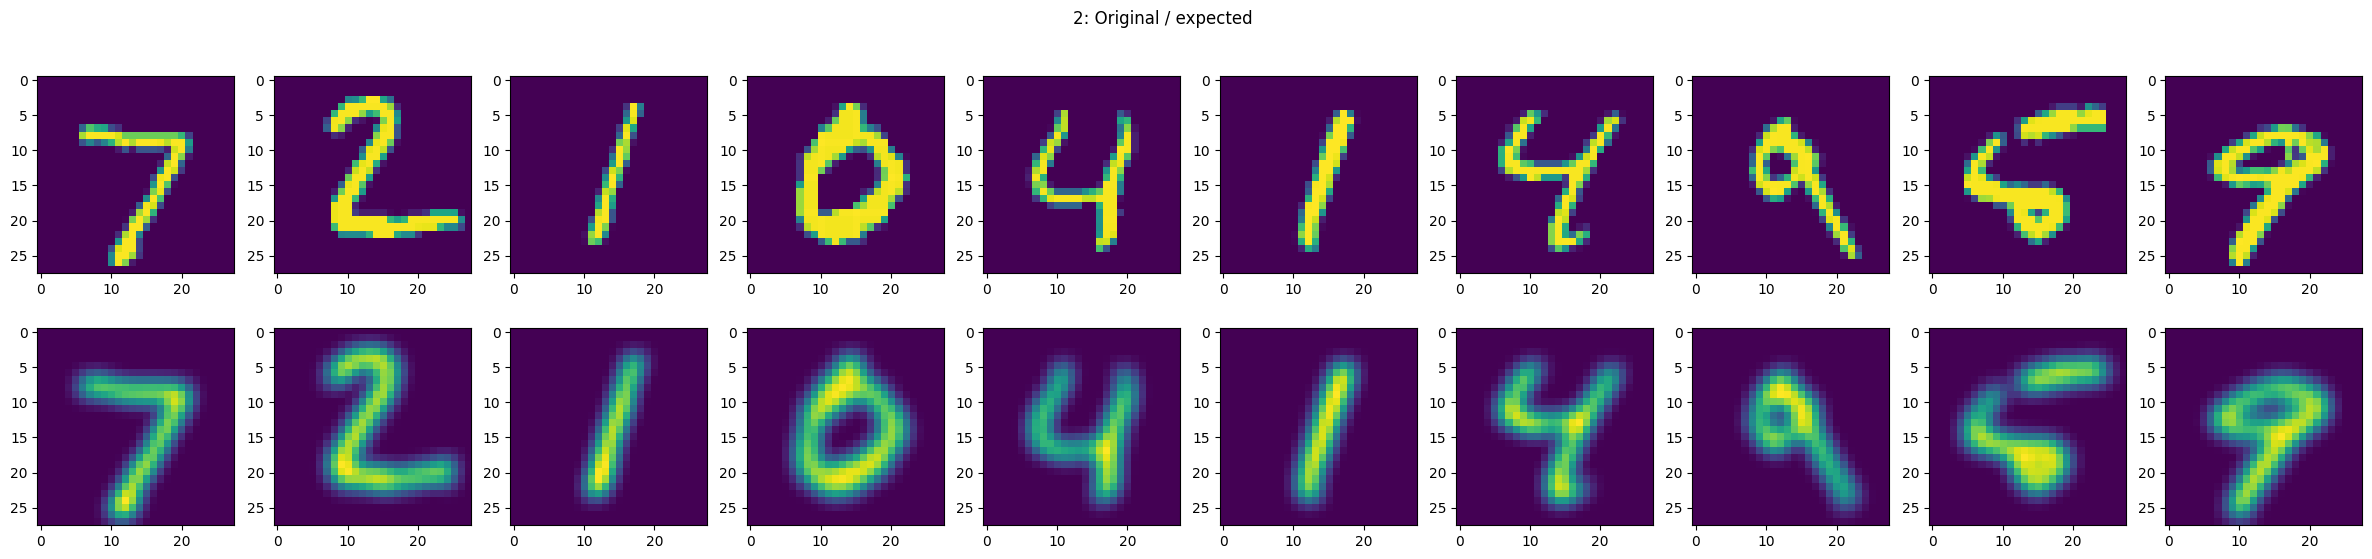

#Epoch: 2, train loss: -13332.25, val loss: -3054.49:  30%|███       | 3/10 [02:01<04:58, 42.65s/it]

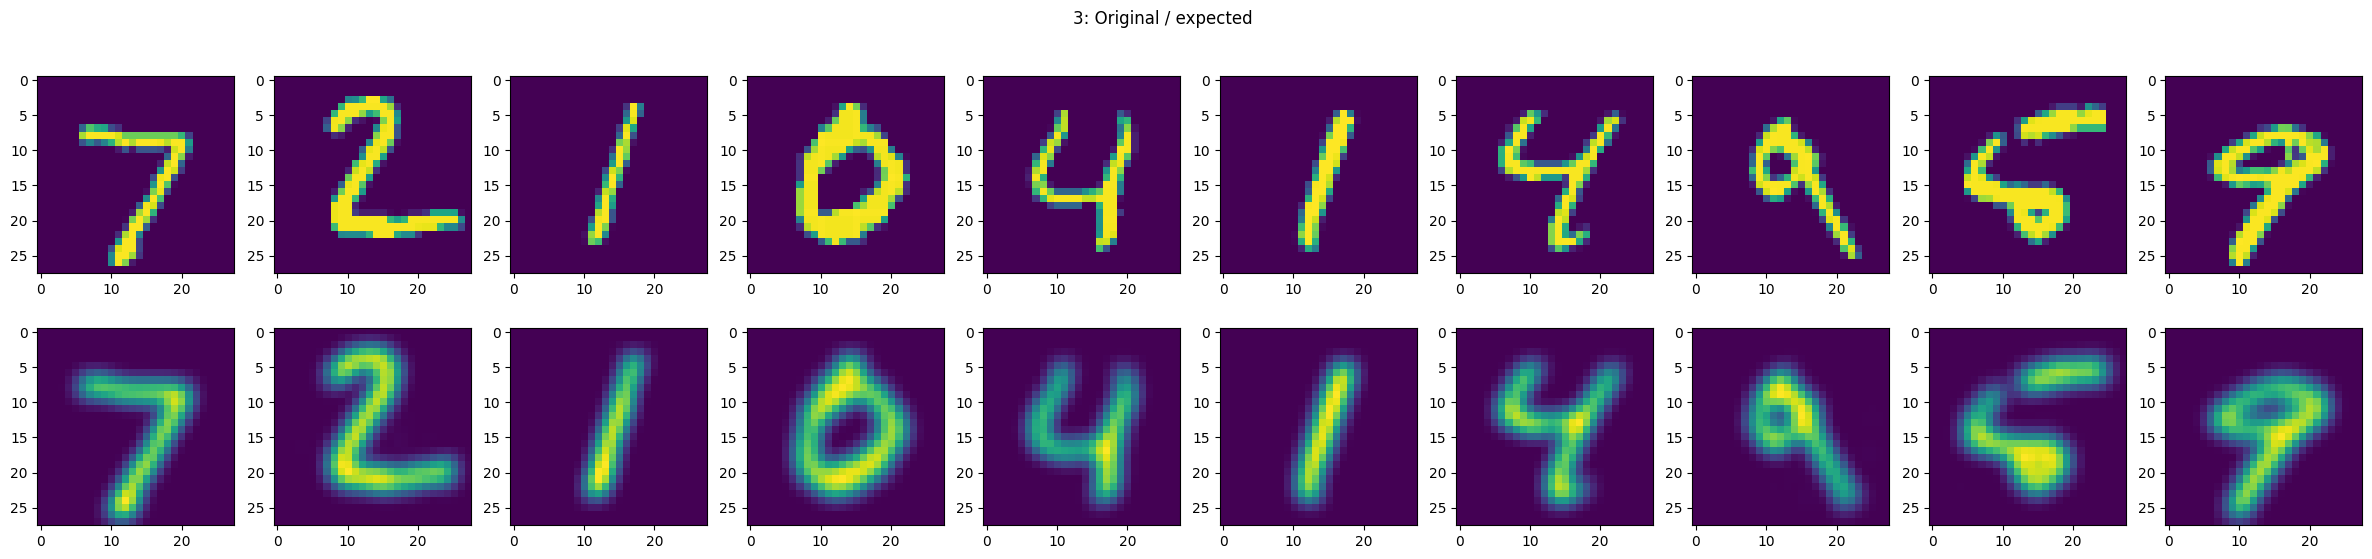

#Epoch: 3, train loss: -21980.67, val loss: -4619.10:  40%|████      | 4/10 [02:42<04:13, 42.31s/it]

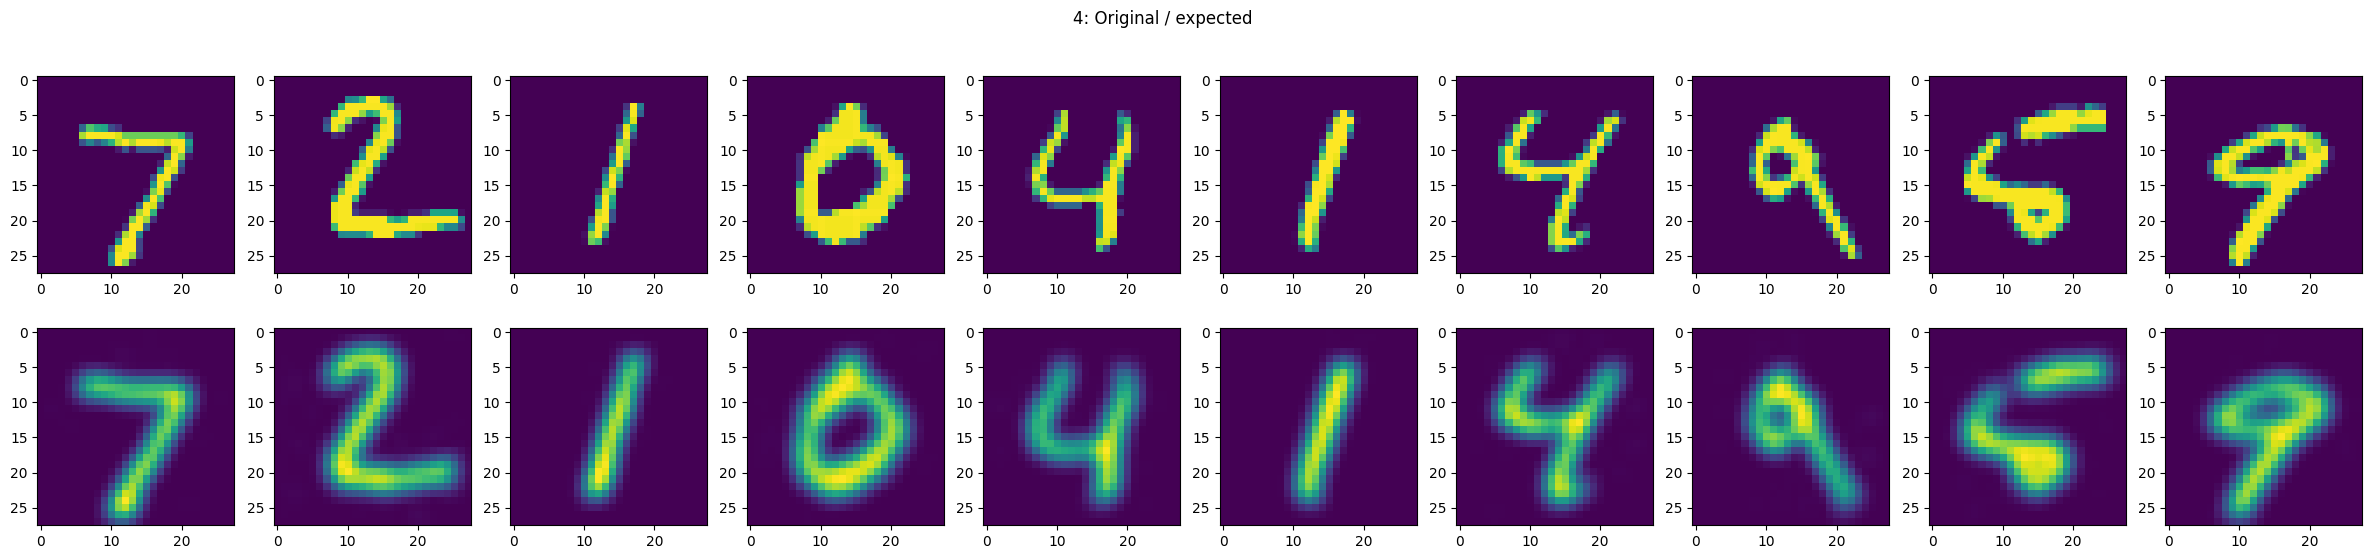

#Epoch: 4, train loss: -32283.20, val loss: -6607.41:  50%|█████     | 5/10 [03:25<03:32, 42.46s/it]

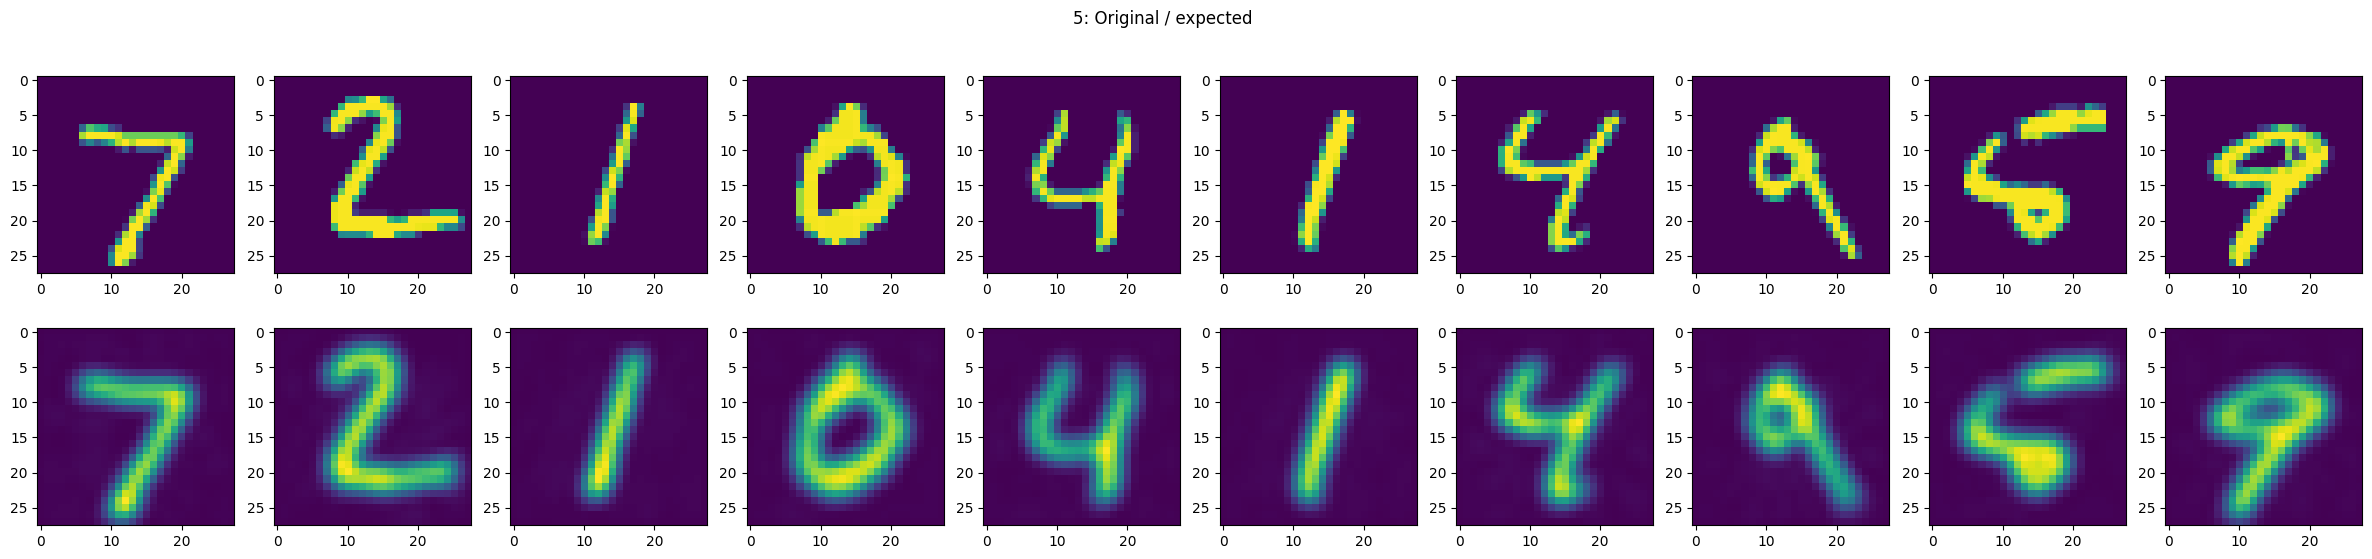

#Epoch: 5, train loss: -44121.96, val loss: -8861.82:  60%|██████    | 6/10 [04:05<02:46, 41.68s/it]

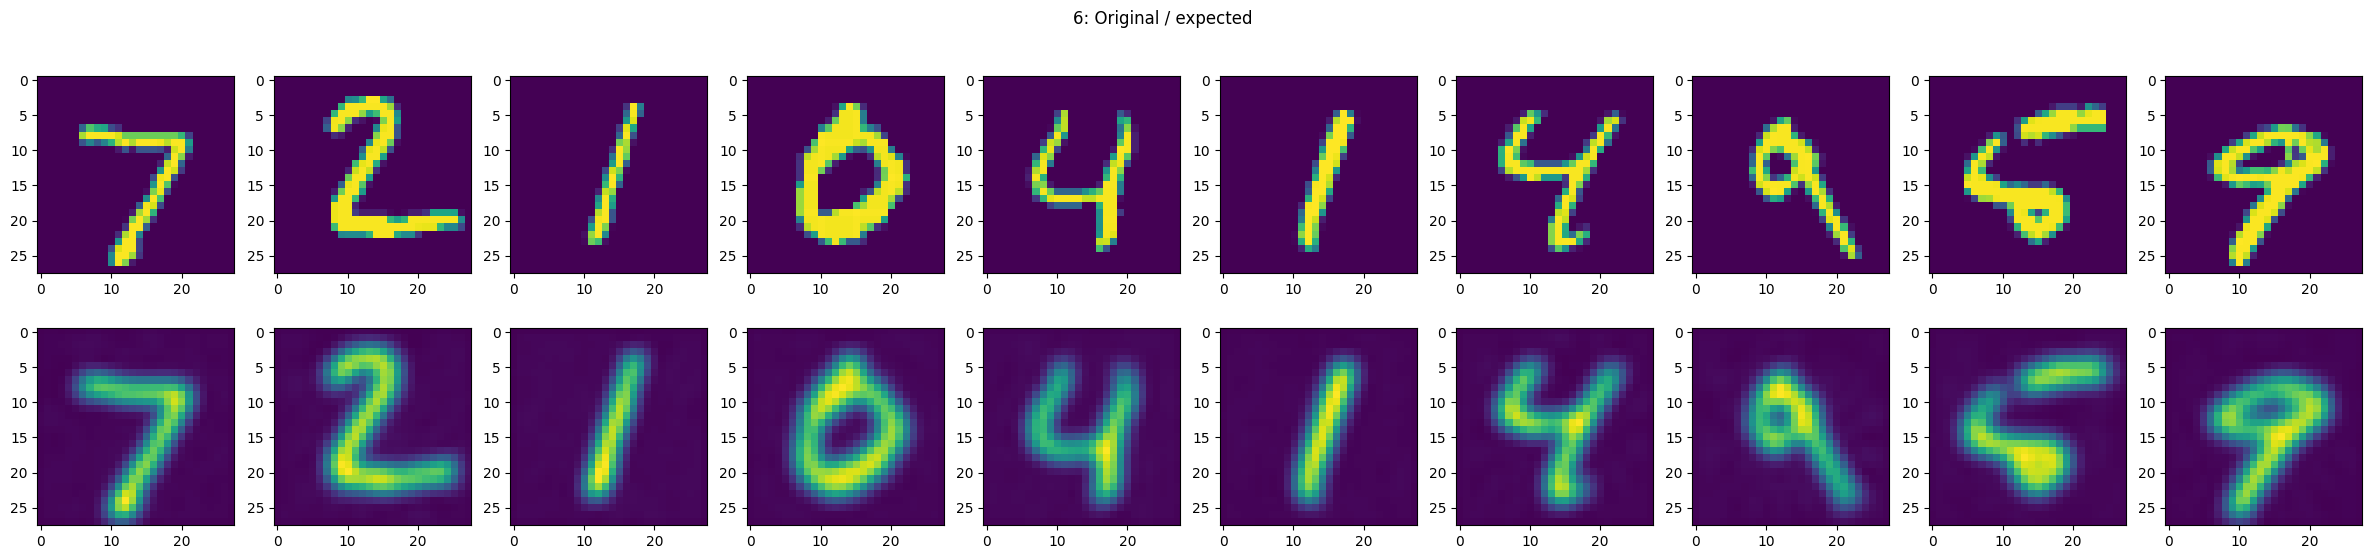

#Epoch: 6, train loss: -57386.11, val loss: -11229.53:  70%|███████   | 7/10 [04:45<02:02, 40.87s/it]

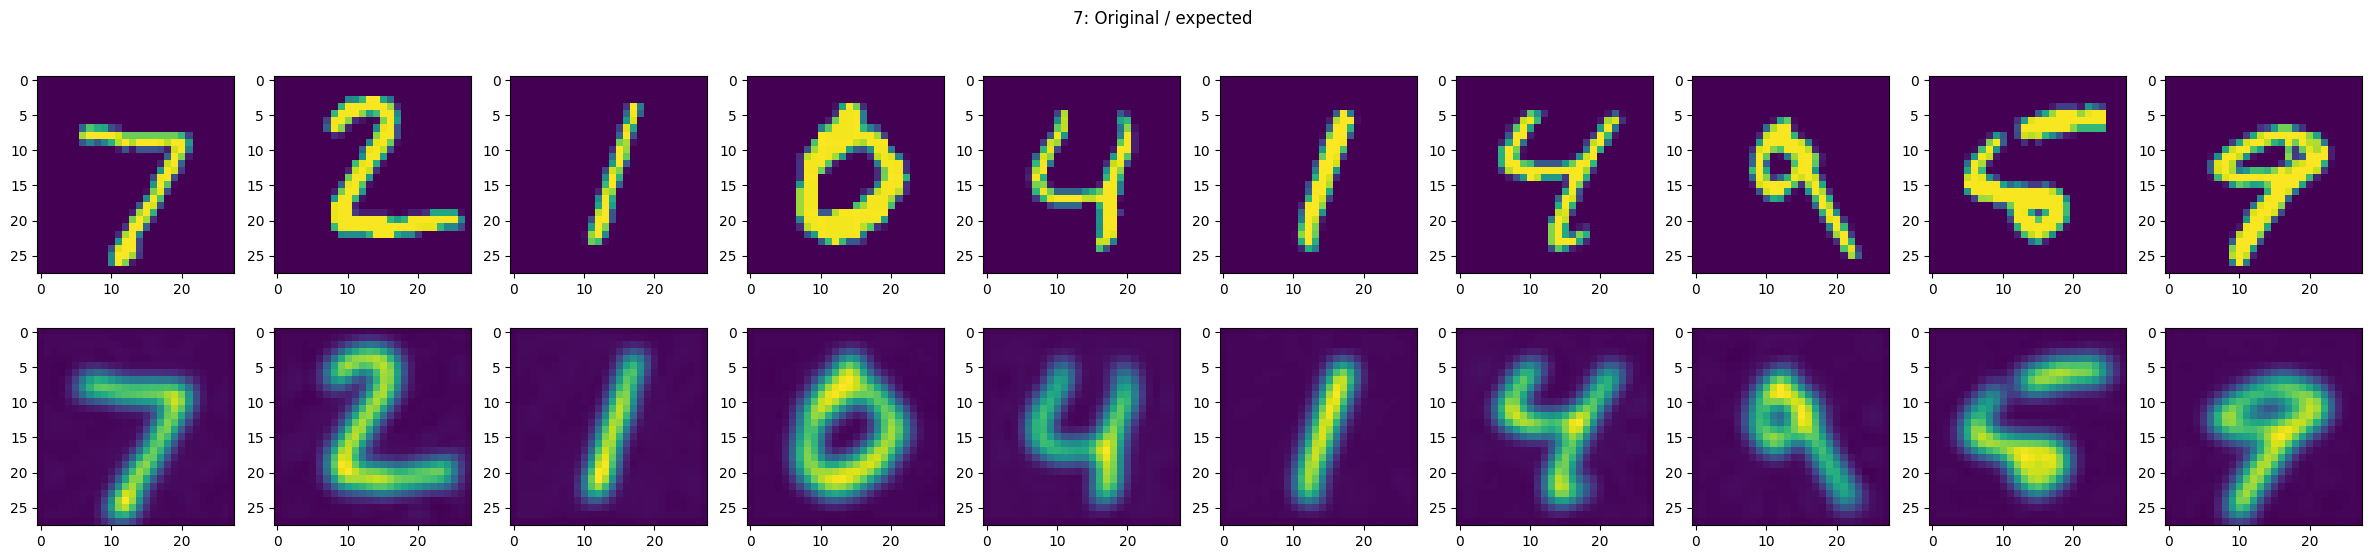

#Epoch: 7, train loss: -71999.16, val loss: -13864.74:  80%|████████  | 8/10 [05:25<01:21, 40.63s/it]

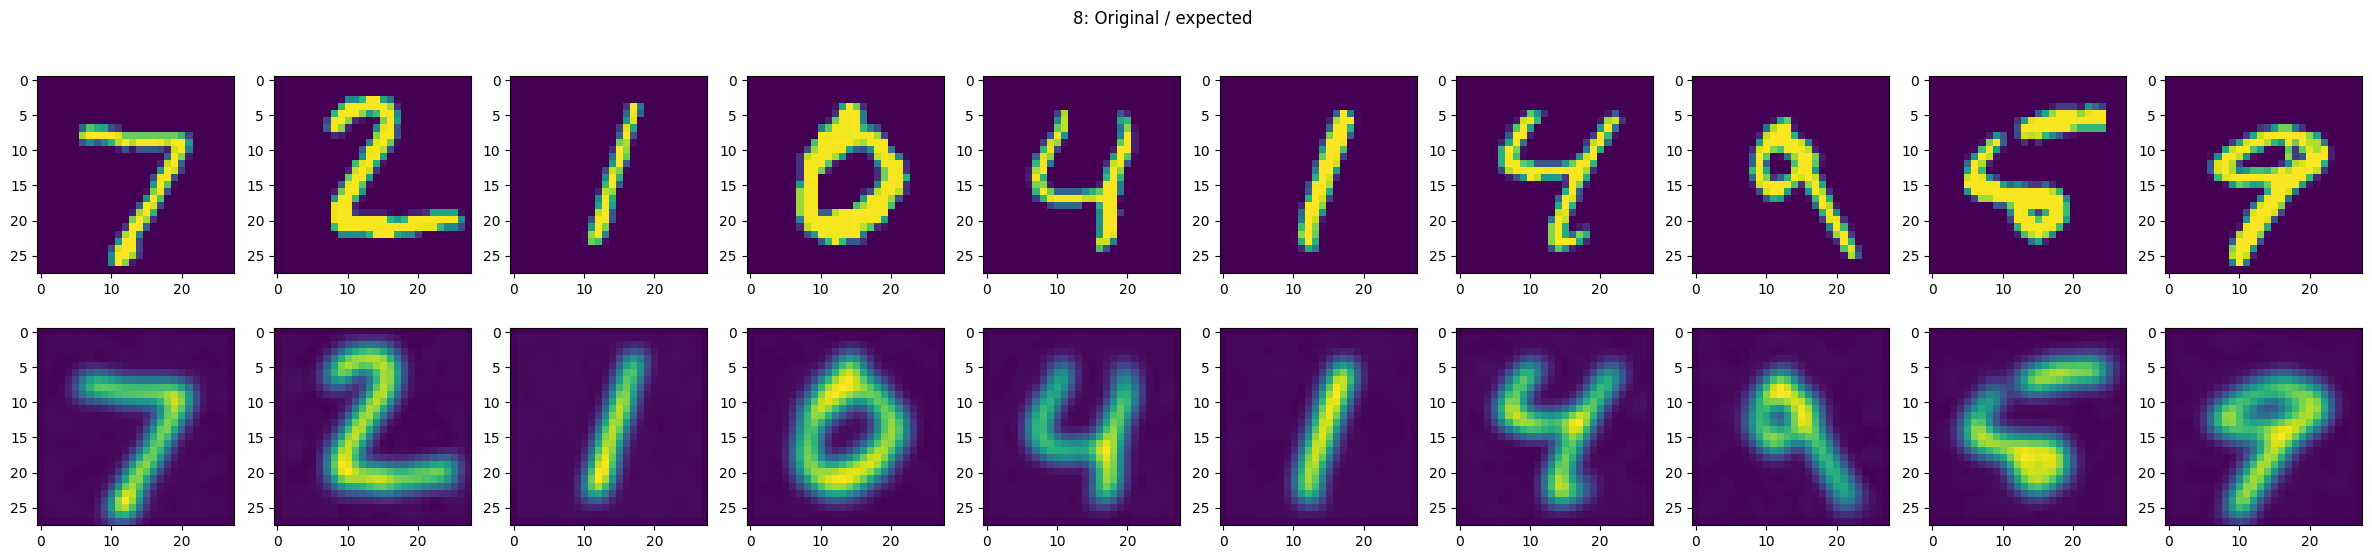

#Epoch: 8, train loss: -87892.74, val loss: -16877.80:  90%|█████████ | 9/10 [06:04<00:40, 40.17s/it]

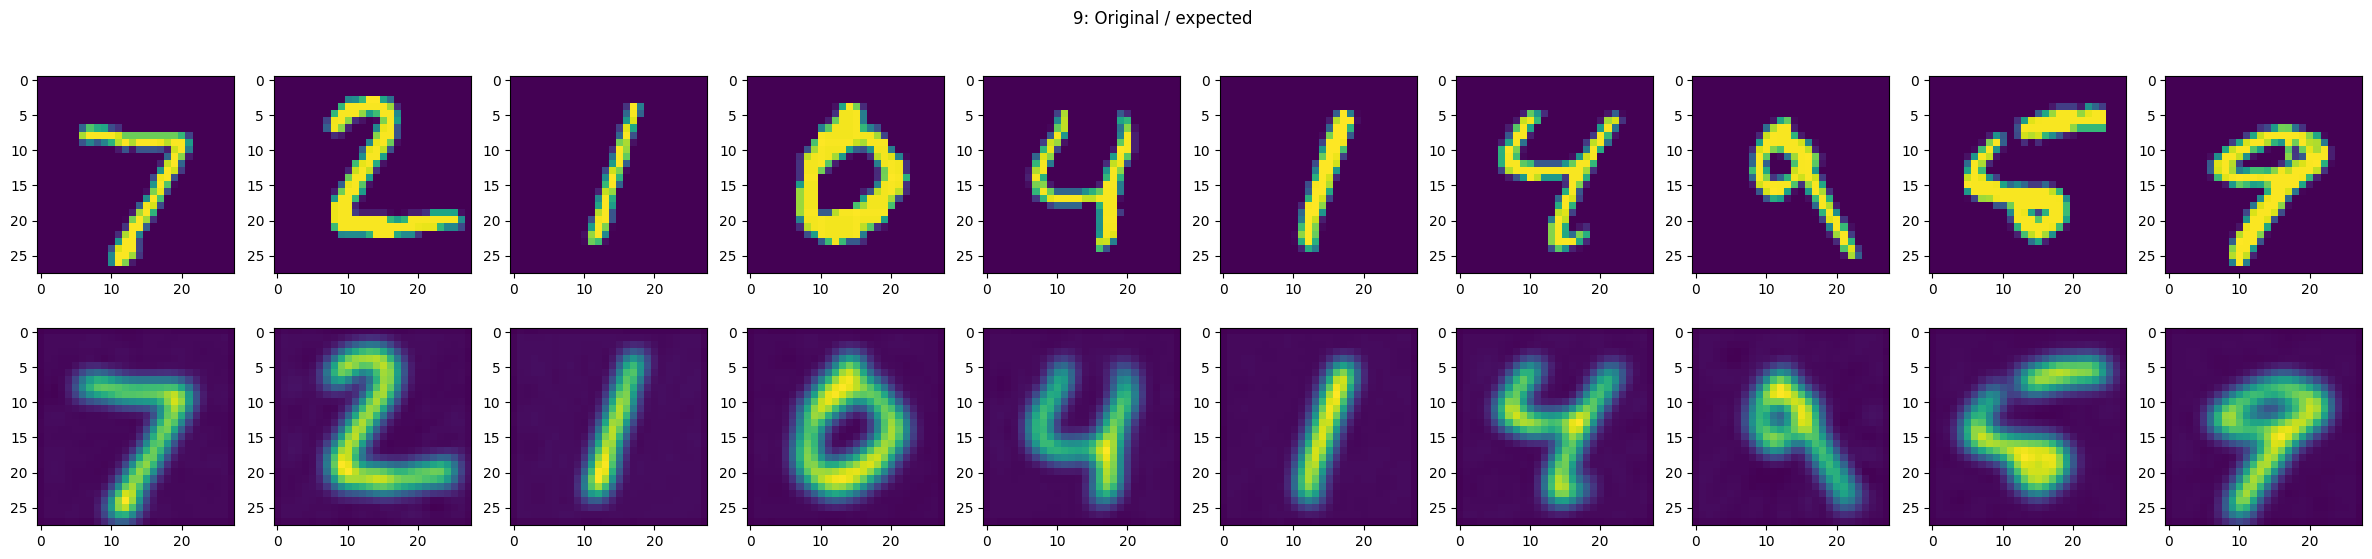

#Epoch: 9, train loss: -105028.20, val loss: -19615.28: 100%|██████████| 10/10 [06:53<00:00, 41.37s/it]


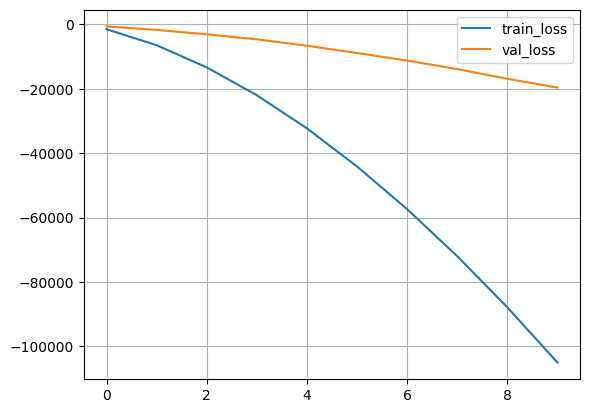

In [10]:
ae2 = AE(hidden_sizes=[16,32], downsize_steps=[0, 1], latent_size=128)
train_ae(ae2, train_dl=dl_train, test_dl=dl_test, num_epochs=10, loss_fn=torch.nn.BCEWithLogitsLoss())

**Question 1** - What are the advantages / disadvantages of using MSE and BCE as reconstruction losses? Which one, in your opinion, makes more sense for this dataset? Which one would you use for a dataset such as CIFAR-10?

**YOUR ANSWER HERE**
MSE does pixel wise similarity, it's good for continuos pixel values like what we have in MNIST.
What is disadvantage result can be blurry, but for MNIST blurry reconstruction is not a problem, what can be said about more complex datasets.

BCE is less sensitive to outliers and noise, also produce sharper images, it makes it working better with bigger datasets. It's nature makes it not good for capturing spacial dependences and correlation of pixels.


### Task for you - visualize the latent space

Run the autoencoder on the validation dataset and visualize the latent embeddings on 2-D space using T-SNE or PCA. Please color each embedding according to it's ground-truth label.

Since the AE returns a tuple of `<reconstructed image>, <latent vector>`, you should be able to re-use the `draw_embeddings` function from Lab 3. 

In [11]:
from sklearn.manifold import TSNE
import numpy as np

def draw_embeddings(net, dl):
    latents = []
    labels = []

    net.eval()
    with torch.no_grad():
        for X, y in dl:
            X = X.to(device)
            _, latent = net(X)
            latents.append(latent.cpu().numpy())
            labels.append(y.cpu().numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latents)


    plt.figure(figsize=(10, 8))
    for i in range(len(np.unique(labels))):
        plt.scatter(latent_tsne[labels == i, 0], latent_tsne[labels == i, 1], label=f'Class {i}')
    plt.title('Latent Space Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid()
    plt.show()



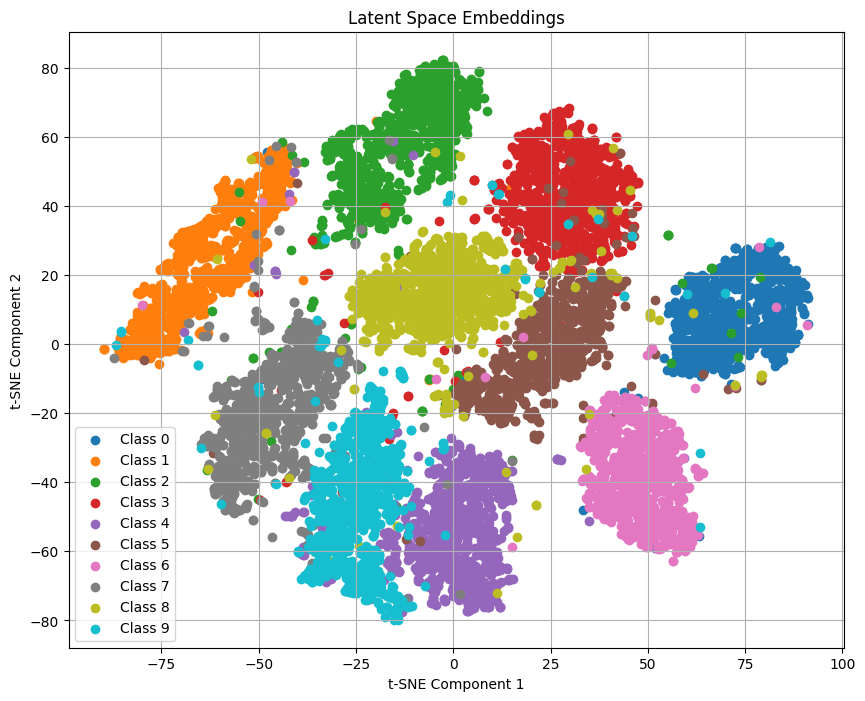

In [12]:
draw_embeddings(ae1, dl_test)

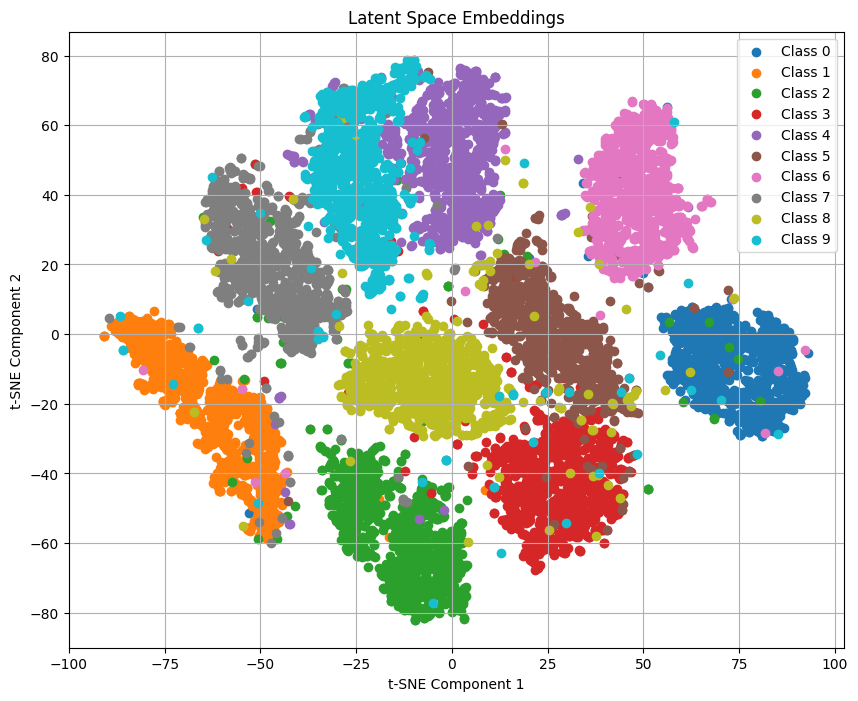

In [13]:
draw_embeddings(ae2, dl_test)

## 2 - Discrete AutoEncoder

We would like our AutoEncoder to model a **discrete** data distribution. 

In other words, if the latent of the AE vector has shape $K$, we want it to take only $K$ different values, represented by one-hot vectors. Notice that this is equivalent to **clustering** - the encoder assigns $x$ into one of the $K$ clusters!


How to achieve that in practice?
* the Encoder should transform each image $x$ into a one-hot vector $z$ of shape $K$
  * we can apply e.g. $softmax$ to the latent vector output by the Encoder in order to obtain the parameters of discrete data distribution $p$
* the Decoder should transform a one-hot vector of shape $K$ sampled from $p$ into something as similar to $x$ as possible.
* we should minimize the **expected** value of cost: 

$$
\mathbb{E}_{z \sim softmax(E(x))} || x - D(z)||^2
$$


The rough training procedure for a sample $x$ will be to:
1. Estimate the distribution: $ p(x) = softmax(E(x)) = [\pi_1, ..., \pi_K]$ with the encoder
2. Sample $M$ one-hot vectors $(z_1, ..., z_M)$ from distribution $p(x)$
3. Use the Decoder to transform $(z_1, ..., z_M)$ into $(\hat{x}_1, ..., \hat{x}_M)$
4. Minimize the cost: $\frac{1}{M} \sum_{i=1}^M ||x - \hat{x_i}||^2$

Step **2** is especially tricky - *how to sample from the distribution generated by the encoder in a differentiable way*? 


### 2a - score function

One of the ways we can do this is to *inject* $p(x)$ into the gradient between the encoder and decoder:

For an image $x$ our Encoder generates distribution parameters $p(x)$ - a vector of shape $K$. We then sample $M$ one-hot vectors from $p(x)$ - we will denote them as $S$ - a matrix of size $(M, K)$, i.e. ($S \in \mathbb{R}^{M \times K}$). $S$ serves as input to the decoder which decodes it into $M$ predicted images $\hat{x}_{1...M}$.

The loss will be formulated as above: $\frac{1}{M} \sum_{i=1}^M ||x - \hat{x_i}||^2$ - we will calculate the gradients of the **decoder** with respect to this loss, just like in an ordinary Autoencoder (in torch we do this with the `.backward()` function, which calculates the gradients, but does not apply them). 

This operation will give us gradients of:
* decoder's parameters
* sampled decoder inputs - $\nabla S \in \mathbb{R}^{M \times K}$

The `backward()` procedure will not be able to go further, as decoder inputs ($S$) are the results of sampling!

In order to propagate $\nabla S$ to the Encoder, we will calculate a matrix of size $(M,K)$: 
$$\nabla S \cdot S \cdot log(p(x))$$ 
and average it along the first axis ($M$ - i.e. the number of our samples from $p(x)$). This results in a vector of shape $K$ - i.e. the same shape as $p(x)$.

Finally, we can pass the constructed vector into the `encoder.backward(...)` function, thus calculating encoder gradients.
Note that all of the above was conducted for a **single** sample $x$. When we will work with batches of samples, we need to remember to take into account the batch dimension as well!

The above method is called score function. In this case, the operation of sampling is non-differentiable, but the gradient flows from decoder to the encoder through the values of vector $p(x) = softmax(E(x))$.

In a case where $K >> M$, most of the elements of "gradient" passed to the encoder will be zeroed-out, which causes a need for large $M$ for the scoring function to work well - this is one of the drawbacks of this method.


### Task for you - train a discrete VAE using scoring function
* modify the below training loop to calculate the loss function 
* use a latent size bigger than number of classes, e.g. 64
* try out a couple of different values of $M$, e.g. 1, 2, 4.
* in each validation step you can simply transform the latent vector into one-hot by setting $1$ in the postition of the largest element of $p$
* after the training, draw the embeddings generated by the encoder. How many clusters are there?

**As you have seen, the scoring function is very much imperfect - if you have trouble training the autoencoder with this method, please don't spend too much time on it and proceed to task 2B!**

In [43]:
def train_discrete_ae_gumbel(net, train_dl, test_dl, M, num_epochs: int = 20, lr: float = 3e-4, loss_fn = None):

  net = net.to(device)
  loss_fn = loss_fn or nn.MSELoss()
  opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=3e-4)  
  
  history = []

  epoch_progress = tqdm(list(range(num_epochs)))
  for i in epoch_progress:
      train_loss = 0
      net.train()
      for iteration, (X_train, y_train) in enumerate(train_dl):
          X_train, y_train = [t.to(device) for t in [X_train, y_train]]
          opt.zero_grad()
          
          p = net.encoder(X_train)
          #latent p. softmax
          #latent. to something
          #decoder(something)
          
          ###### YOUR CODE HERE ########
          # * sample one-hots from p (those tensors should have set requires_grad to True!)
          S = torch.softmax(p, dim=-1)
          
          onehot_indices = torch.multinomial(S, M, replacement=True)
          onehot_vectors = torch.zeros(M, p.size(1), device=device)
          onehot_vectors.scatter_(1, onehot_indices.unsqueeze(-1), 1, 1)
          onehot_vectors.requires_grad_(True)


          decoded = net.decoder(onehot_vectors)

          loss = loss_fn(X_train.unsqueeze(1).expand(-1, M, -1), decoded)


          loss.backward()

          grad_S = onehot_vectors.grad
          grad_p = grad_S * S * torch.log_softmax(p, dim=-1)
          encoder_grad = grad_p.mean(dim=0)
          p.backward(encoder_grad)
          
          ##############################

          opt.step()
          train_loss += loss.item()
          
      val_loss = 0
      net.eval()
      with torch.no_grad():
          for iteration, (X_val, y_val) in enumerate(test_dl):
              X_val, y_val = [t.to(device) for t in [X_val, y_val]]

              latent = net.encoder(X_val)
              softmax_latent = torch.softmax(latent, -1)

              ### YOUR CODE here
              # transform the softmax_latent to one-hot vectors 
              onehot_latent = ...
              _, max_indices = torch.max(softmax_latent, dim=-1)
              onehot_latent = torch.zeros_like(softmax_latent)
              onehot_latent.scatter_(dim=-1, index=max_indices.unsqueeze(-1), value=1)
              
              ###
              X_pred = net.decoder(onehot_latent)
              if iteration == 0:
                draw_reconstruction(
                    X_val[:10].detach().cpu().numpy(), X_pred[:10].detach().cpu().numpy(), epoch=i
                )
              loss = loss_fn(X_val, X_pred)
              val_loss += loss.item()
      
      epoch_progress.set_description(f'#Epoch: {i}, train loss: {train_loss:.2f}, val loss: {val_loss:.2f}')
      history.append({"e": i, "train_loss": train_loss, "val_loss": val_loss})
    
  for m in ["train_loss", "val_loss"]:
      plt.plot([h["e"] for h in history], [h[m] for h in history], label=m)
  
  plt.grid()
  plt.legend()
  plt.show()

In [45]:
net = AE(hidden_sizes=[16,32], downsize_steps=[0, 1], latent_size=128)
train_discrete_ae_gumbel(net, dl_train, dl_test, 2, num_epochs=20, lr=3e-4)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Expected index [128, 2] to be smaller than self [2, 128] apart from dimension 1

### 2b - Gumbel-softmax

An alternative way is to approximate the discrete distribution with a continuous one, through a Gumbel-softmax trick.

Suppose we have a discrete distribution with probabilities:

$$\pi = [\pi_1, ..., \pi_K]$$

In order to sample from such a distribution, we can sample a vector of $K$ values from a uniform distribution:

$$
u = [u_1, ..., u_K];\\
u \sim Unif(0,1)\
$$

then, transform it into a vector $g$:

$$g = -log(-log(u)) = [g_1, ..., g_K]$$

Let's now sum $g$ and $log(\pi)$ and divide it by **temperature** $\tau$. Finally, let's apply $softmax$ to the resulting vector:

$$
y = softmax((g + log(\pi)) / \tau)
$$

The result of this operation is a vector of $K$ values which sums up to 1. Since vectors $g$ come from a continuous uniform distribution and vectors $y$ are a function of $g$, $\pi$ and $\tau$, it turns out that vectors $y$ come from a continuous distribution with parameters $\pi$ and $\tau$.

### Task for you - please implement sampling from such a distribution

* select a non-trivial categorical distribution $\pi$
* try out sampling for different values of $\tau$, ranging between 10^2 ... 10^-5
* for each $\tau$ sample 1000 vectors and calculate the mean sample


In [22]:
def gumbel_sample(p: torch.Tensor, t: float, n: int):
  """
  p: tensor of shape [d] - represents a categorical distribution with `d` categories - i.e. p should consists of d non-negative values which sum to 1.
  t: temperature
  n: number of samples

  returns:
    a tensor of shape [n, d] with n samples from distribution Y
  """


  u = torch.rand(n, len(p))
    
  g = -torch.log(-torch.log(u))
  g += torch.log(p)
  y = (g / t)
  y = torch.softmax(y, dim=-1)
  return y


p = torch.tensor([.25, .50, .15, .1]).float()
tau_values = [10 ** i for i in range(2, -6, -1)]
num_samples = 1000

for tau in tau_values:
    samples = gumbel_sample(p, tau, num_samples)
    mean_sample = samples.mean(dim=0)
    print(f"Tau: {tau}, Mean Sample: {mean_sample}")




Tau: 100, Mean Sample: tensor([0.2504, 0.2521, 0.2493, 0.2482])
Tau: 10, Mean Sample: tensor([0.2551, 0.2729, 0.2411, 0.2309])
Tau: 1, Mean Sample: tensor([0.2645, 0.4180, 0.1799, 0.1376])
Tau: 0.1, Mean Sample: tensor([0.2473, 0.4858, 0.1616, 0.1053])
Tau: 0.01, Mean Sample: tensor([0.2447, 0.5009, 0.1538, 0.1006])
Tau: 0.001, Mean Sample: tensor([0.2317, 0.5160, 0.1443, 0.1080])
Tau: 0.0001, Mean Sample: tensor([0.2611, 0.4880, 0.1540, 0.0969])
Tau: 1e-05, Mean Sample: tensor([0.2640, 0.4810, 0.1560, 0.0990])


**Question 2** - what have you noticed for large and small values of $\tau$?
#The highter tau, the more uniform distribution is, the smaller tau, the more sparse distrubution we get
**YOUR ANSWER HERE**

### Task for you - train a discrete autoencoder with Gumbel-softmax

* in each training step, for each image $x$:
  * generate distribution $E(x) = \pi_x$ with the decoder
  * sample $M$ one-hot vectors $[z_1^x, ..., z_M^x]$ from $\pi_x$
  * use the decoder to transform $[z_1^x, ..., z_M^x]$ into $[\hat{x_1}, ..., \hat{x_M}]$
  * minimize the mean difference (MSE or BCE) between $x$ and $[\hat{x_1}, ..., \hat{x_M}]$  
* with each epoch, decrease the temperature $\tau$
* in each validation step you can simply transform the latent vector into one-hot using softmax

After training:
* visualize the latent clusters with colors from ground-truth labels (just like with the vanilla AE)
* for each dimension of the latent generate a one-hot vector and visualize the output of the decoder for that vector. For example, if our latent size was $4$, we would visualize in total four decoder outputs for the following one-hot vectors:
  * $[1, 0, 0, 0]$
  * $[0, 1, 0, 0]$
  * $[0, 0, 1, 0]$
  * $[0, 0, 0, 1]$

In [24]:
def train_discrete_ae_gumbel(net, train_dl, test_dl, num_epochs: int = 20, lr: float = 3e-4, loss_fn = None):

  net = net.to(device)
  loss_fn = loss_fn or nn.MSELoss()
  opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=3e-4)  
  
  history = []

  epoch_progress = tqdm(list(range(num_epochs)))
  for i in epoch_progress:
      train_loss = 0
      net.train()
      for iteration, (X_train, y_train) in enumerate(train_dl):
          X_train, y_train = [t.to(device) for t in [X_train, y_train]]
          opt.zero_grad()
          
          latent = net.encoder(X_train)

      
          
          ###### YOUR CODE HERE ########


          p = net.decoder(X_train)
          z = gumbel_sample(p, tau, n=1)
          decoded = net.decoder(z)
        #loss = ...
          loss = loss_fn(X_train, decoded)
          ##############################

          loss.backward()
          opt.step()
          train_loss += loss.item()
          
      val_loss = 0
      net.eval()
      with torch.no_grad():
          for iteration, (X_val, y_val) in enumerate(test_dl):
              X_val, y_val = [t.to(device) for t in [X_val, y_val]]

              latent = net.encoder(X_val)
              softmax_latent = torch.softmax(latent, -1)



              ### YOUR CODE here
              # transform the softmax_latent to one-hot vectors 
              #onehot_latent = ...
              _, max_indices = torch.max(softmax_latent, dim=-1)
              onehot_latent = torch.zeros_like(softmax_latent)
              onehot_latent.scatter_(dim=-1, index=max_indices.unsqueeze(-1), value=1)
              ###
              X_pred = net.decoder(onehot_latent)
              if iteration == 0:
                draw_reconstruction(
                    X_val[:10].detach().cpu().numpy(), X_pred[:10].detach().cpu().numpy(), epoch=i
                )
              loss = loss_fn(X_val, X_pred)
              val_loss += loss.item()
      
      epoch_progress.set_description(f'#Epoch: {i}, train loss: {train_loss:.2f}, val loss: {val_loss:.2f}')
      history.append({"e": i, "train_loss": train_loss, "val_loss": val_loss})
    
  for m in ["train_loss", "val_loss"]:
      plt.plot([h["e"] for h in history], [h[m] for h in history], label=m)
  
  plt.grid()
  plt.legend()
  plt.show()



In [27]:
net = AE(hidden_sizes=[16,32], downsize_steps=[0, 1], latent_size=128)
train_discrete_ae_gumbel(net, dl_train, dl_test, num_epochs=20, lr=3e-4)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 128x6272)